In [638]:
"""
This example is from doi:10.1021/acscatal.7b03205, Huber et al.

ethylene dimerization and oligomerization to 1 butene
"""
# load a bunch of stuff
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import cm
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
plt.switch_backend('agg')  # needed for saving figures
import csv
from pydas.dassl import DASSL
import os

import re
import operator
import pandas as pd
import pylab
from cycler import cycler
import seaborn as sns
import os
import multiprocessing
import sys
import rmg
import rmgpy

# this chemkin file is from the cti generated by rmg
gas = ct.Solution('./chem_annotated.cti', 'gas')
surf = ct.Interface('./chem_annotated.cti', 'surface1', [gas])

print("This mechanism contains {} gas reactions and {} surface reactions".format(gas.n_reactions, surf.n_reactions))

This mechanism contains 0 gas reactions and 113 surface reactions


In [639]:
i_c2h4 = gas.species_index('C2H4(2)')
i_nheptane = gas.species_index('n-heptane')
i_c4h8_1 = gas.species_index('C4H8-1(3)')  # 1 butene
i_c4h8_2 = gas.species_index('C4H8-2(4)')  # 2 butene
# i_hx = gas.species_index('HX(5)')
# i_c6h12_1 = gas.species_index('C6H12-1(7)')
# i_c6h12_2 = gas.species_index('C6H12-2(8)')
# i_c6h12_3 = gas.species_index('C6H12-3(9)')
# i_c6h12_1_3 = gas.species_index('C6H12-1-3(10)')
# i_c6h12_2_3 = gas.species_index('C6H12-2-3(11)')

# unit conversion factors to SI
mm = 0.001
cm = 0.01
ms = mm
minute = 60.0

cat_area_per_vol = 5.9e8  # in m-1


In [640]:
species_dict = rmgpy.data.kinetics.KineticsLibrary().get_species('species_dictionary.txt')
keys = species_dict.keys()
# get the first listed smiles string for each molecule
smile = []
for s in species_dict:
    # treating HX separately because smiles translation drops the H
    if s == 'HX(5)':
        smile.append('H[Pt]')
        continue
    smile.append(species_dict[s].molecule[0])
    if len(species_dict[s].molecule) is not 1:
        print('There are %d dupllicate smiles for %s:' % (len(species_dict[s].molecule), s))
        for a in range(len(species_dict[s].molecule)):
            print('%s' % (species_dict[s].molecule[a]))

# translate the molecules from above into just smiles strings
smiles = []
for s in smile:
    try:
        smiles.append(s.to_smiles())
    except AttributeError:
        print("Cannot convert {} to SMILES, translating manually".format(s))
        smiles.append(s)
names = dict(zip(keys, smiles))

Cannot convert H[Pt] to SMILES, translating manually


In [641]:
def semibatch(gas, surf, temp, pressure, volume, mol_in, verbose=False, sens=False):
    """

    :param gas: from cti
    :param surf: from cti
    :param temp: Kelvin
    :param pressure: Pa
    :param volume: m^3
    :param mol_in: ratio
    :param verbose:
    :param sens:
    :return:
    """
    
    overall_fluxes = {}
    
    def combine_fluxes(fluxes, time_delta):
        fluxes = fluxes.split('\n')
        fluxes = [x for x in fluxes if x != '']  # remove empty items
        fluxes.pop(0)  # remove all species from first entry

        for line in fluxes:
            s1,s2,f,r = line.split()
            key = names[s1] + ' ' + names[s2]  # replace simulation names with smiles

            if key in overall_fluxes:
                overall_fluxes[key] = overall_fluxes[key] + time_delta * (float(f) + float(r))  # multiply by delta t because each time step is different
            else:
                overall_fluxes[key] = time_delta * (float(f) + float(r))
        return overall_fluxes
            
        
    cat_area = cat_area_per_vol * volume

    c2h4, nh = mol_in
    c2h4 = str(c2h4)
    nh = str(nh)
    X = str('C2H4(2):' + c2h4 + ', n-heptane:' + nh)  # gas concentrations

    surf.TP = temp, pressure
    surf.coverages = 'X(1):1.0'

    # create an upstream reservoir that will supply the reactor. The temperature
    #  and pressure of the upstream reservoir of pure ethylene
    gas.TPX = temp, pressure, 'C2H4(2):1'
    upstream = ct.Reservoir(gas)

    # set the gas to the specified input concentrations
    gas.TPX = temp, pressure, X
    exhaust = ct.Reservoir(gas)

    # Now create the reactor object with a differnet initial state.  Turn energy off
    # so the temperature stays at its initial value
    r = ct.IdealGasReactor(gas, energy='off')

    # Set its volume. In this problem, the reactor volume is fixed, so
    # the initial volume is the volume at all later times.
    r.volume = volume

    # Add the reacting surface to the react or. The area is set to the desired
    # catalyst area in the reactor.
    rsurf = ct.ReactorSurface(surf, r, A=cat_area)

    # create a valve to feed in ethylene from the reservoir to the reactor if the pressure drops
    pressureRegulator = ct.Valve(upstream=upstream,
                                 downstream=r,
                                 K=1e-3)  # CVODES at 2e-2 when the second valve is on

    # trying to keep pressure from building up
    pressureRegulator2 = ct.Valve(upstream=r,
                                  downstream=exhaust,
                                  K=1e-4)

    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12

    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-10
    sim.atol = 1.0e-20

    # rxn_time = np.linspace(1E-5, np.log10(3600), 1000001)  # from 0s to 3600s (1 hour)
    rxn_time = np.logspace(-5, np.log10(60), 1000001)  # from 0s to 3600s (1 hour), log spacing
    gas_mole_fracs = np.zeros([gas.n_species, len(rxn_time)])
    surf_site_fracs = np.zeros([surf.n_species, len(rxn_time)])
    p = np.zeros(len(rxn_time))
    temperature = np.zeros(len(rxn_time))
    v = np.zeros(len(rxn_time))

    if verbose is True:
        print('     time        X_C2H4       X_C4H8-1')

    surf.set_multiplier(1.0)
    if sens is not False:
        surf.set_multiplier(1.0 + sens[0], sens[1])
    for i in range(len(rxn_time)):
        time = rxn_time[i]  # define time in the reactor
        sim.advance(time)  # Advance the simulation to next set time
        # p[i] = gas.P / ct.one_atm
        p[i] = gas.P / 1e6  # MPa
        gas_mole_fracs[:, i] = gas.X
        surf_site_fracs[:, i] = surf.coverages
        temperature[i] = gas.T
        v[i] = r.volume

        if verbose is True:
            if not i % 10000:
                print('  {0:10f}  {1:10f} '.format(time, *gas[
                    'C2H4(2)', 'C4H8-1(3)'].X))

        # make reaction diagrams
        out_dir = 'rxnpath'
        os.path.exists(out_dir) or os.makedirs(out_dir)
#         elements = ['H', 'C']
        """
        Times to generate rxnpath diagrams (times_of_interest):
        [0, 116873, 233746, 350619, 467492, 584365, 792183, 909056, 1000000]

        corresponds to:
         - at the beginning of time, 1e-5 seconds
         - just after 1e-4 seconds
         - just after 1e-3 seconds
         - just after 1e-2 seconds
         - just after 1e-1 seconds
         - just after 1 second
         - just after 1 minute
         - just after 10 minutes
         - at an hour
         
        was running [0, 1e2, 1e3, 1e4, 1e5, 1e6] before
        """
#         times_of_interest = [0, 116873, 233746, 350619, 467492, 584365, 792183, 909056, 1000000]
        times_of_interest = [231625]
    
        if sens is False:
            
            diagram = ct.ReactionPathDiagram(surf, 'H')
            data = diagram.get_data()
            time_delta = time - rxn_time[i-1]
            combine_fluxes(data, time_delta)
            
            
#             for l in times_of_interest:
#                 if i == l:
#                     time = '{:0.1e}'.format(rxn_time[l])

#                     diagram = ct.ReactionPathDiagram(surf, 'X')
#                     data = diagram.get_data()
#                     fluxes.append(data)
#                     print(data)
#                     diagram.title = 'rxn path'
#                     diagram.label_threshold = 1e-9
#                     dot_file = out_dir + '/x-' + time + '.dot'
#                     img_file = out_dir + '/x-' + time + '.png'
#                     img_path = os.path.join(out_dir, img_file)
#                     diagram.write_dot(dot_file)
#                     os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))

#                     for element in elements:
#                         diagram = ct.ReactionPathDiagram(surf, element)
#                         diagram.title = element + 'rxn path'
#                         diagram.label_threshold = 1e-9
#                         dot_file = out_dir + '/surf-' + time + '-' + element + '.dot'
#                         img_file = out_dir + '/surf-' + time + '-' + element + '.png'
#                         img_path = os.path.join(out_dir, img_file)
#                         diagram.write_dot(dot_file)
#                         os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
        else:
            pass


    # check to see if the pressure stays the same throughout
    maxPressureRiseAllowed = 1e-2  # MPa
    pressureDifferential = np.amax(p) - np.amin(p)
    if abs(pressureDifferential) > maxPressureRiseAllowed:
        print("WARNING: Non-trivial pressure change of {0:3f} MPa in reactor!".format(pressureDifferential))

    surf.set_multiplier(1.0)  # resetting things, just incase sensitivity was running
    return gas_mole_fracs, surf_site_fracs, rxn_time, p, overall_fluxes


def plot(data, log=False):
    gas_mole_fracs, surf_site_fracs, rxn_time, pressure, fluxes = data

    #Plot out simulations results
    fig = pylab.figure(dpi=300, figsize=(12, 8))
    gs = gridspec.GridSpec(2, 1)
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    y_min = 1E-2

    for i in range(gas.n_species):
        if np.max(gas_mole_fracs[i,:]) > y_min:
            if log is True:
                ax0.loglog(rxn_time, gas_mole_fracs[i, :], label=names[gas.species_name(i)])
                ax0.set_xlim(1e-5, max(rxn_time))
                ax0.set_ylim(1e-4, 2)
            else:
                # ax0.semilogy(rxn_time, gas_mole_fracs[i,:], label=gas.species_name(i) )
                ax0.plot(rxn_time, gas_mole_fracs[i, :], label=names[gas.species_name(i)])
                ax0.set_xlim(0., max(rxn_time))
                ax0.set_ylim(y_min, 1.1)

    for i in range(surf.n_species):
        if np.max(surf_site_fracs[i,:]) > y_min:
            if log is True:
                ax1.loglog(rxn_time, surf_site_fracs[i, :], label=names[surf.species_name(i)])
                ax1.set_xlim(1e-5, max(rxn_time))
                ax1.set_ylim(1e-4, 2)
            else:
                # ax1.semilogy(rxn_time, surf_site_fracs[i,:], label=surf.species_name(i) )
                ax1.plot(rxn_time, surf_site_fracs[i, :], label=names[surf.species_name(i)])
                ax1.set_xlim(0.,max(rxn_time))
                ax1.set_ylim(y_min, 1.1)

    # putting legend on the outside of the plot for now because it's really long
    box = ax0.get_position()
    ax0.set_position([box.x0, box.y0, box.width * 0.5, box.height])
    ax0.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, shadow=False,)
    box2 = ax1.get_position()
    ax1.set_position([box2.x0, box2.y0, box2.width * 0.5, box2.height])
    ax1.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, shadow=False,)

    ax0.set_ylabel("gas-phase mole fraction", fontsize=14)
    ax0.set_ylim(y_min, 1.)

    # ax0.set_xlabel("Time(s)", fontsize=20)
    ax1.set_ylabel("surface site fraction", fontsize=14)
    #ax0.xaxis.set_major_locator(MaxNLocator(6))
    #ax0.yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
    #ax0.tick_params(axis='both', which='major', labelsize=10)
    out_dir = 'figures'
    os.path.exists(out_dir) or os.makedirs(out_dir)
    ax1.set_xlabel("Time(s)", fontsize=14)
    if log is True:
        fig.savefig(out_dir + '/batch-log.pdf', bbox_inches='tight')
    else:
        fig.savefig(out_dir + '/batch.pdf', bbox_inches='tight')
    plt.close()

In [642]:
#######################################################################
# Input Parameters
#######################################################################

t_in = 423.15  # K, uniform temperature profile
gas_names = gas.species_names
surf_names = surf.species_names

p = 35  # bar or 3.5 MPa
pressure = p * 1e5  # Pa
volume = 0.3e-3  # m^3

f_ethylene = 2
f_nheptane = 1
ratio_in = [f_ethylene, f_nheptane]
print('Starting model simulation')
a = semibatch(gas, surf, t_in, pressure, volume, ratio_in, verbose=True)
print('Finished model simulation')
gas_mole_fracs, surf_site_fracs, rxn_time, pressure1,fluxes = a
# plot(a, log=True)
# plot(a)

# plt.semilogx(rxn_time, pressure1)
# plt.savefig('pressure.pdf')

Starting model simulation
     time        X_C2H4       X_C4H8-1
    0.000010    0.664366 
    0.000012    0.664161 
    0.000014    0.663865 
    0.000016    0.663459 
    0.000019    0.662940 
    0.000022    0.662333 
    0.000026    0.661695 
    0.000030    0.661109 
    0.000035    0.660670 
    0.000041    0.660455 
    0.000048    0.660515 
    0.000056    0.660870 
    0.000065    0.661532 
    0.000076    0.662512 
    0.000089    0.663825 
    0.000104    0.665490 
    0.000121    0.667527 
    0.000142    0.669950 
    0.000166    0.672768 
    0.000194    0.675981 
    0.000227    0.679581 
    0.000265    0.683548 
    0.000310    0.687850 
    0.000362    0.692444 
    0.000423    0.697273 
    0.000495    0.702272 
    0.000579    0.707366 
    0.000676    0.712473 
    0.000790    0.717507 
    0.000924    0.722381 
    0.001080    0.727010 
    0.001262    0.731318 
    0.001476    0.735235 
    0.001725    0.738706 
    0.002016    0.741690 
    0.002357    0.744164 

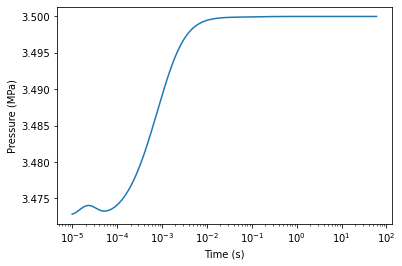

In [629]:
plot(a, log=True)
plot(a)

plt.semilogx(rxn_time, pressure1)
plt.xlabel("Time (s)")
plt.ylabel("Pressure (MPa)")
plt.savefig('pressure.pdf')

In [656]:
overall_fluxes = fluxes
overall_fluxes

'\nC2H4(2) HX(5) C2H3X(27) C4H6(7) C4H5X(57) C6H8(9) C4H5X(56) C4H8-1(3) C2H5X(30) C4H10(141) C4H9X(45) C6H12(149) C4H7X(32) C4H7X(31) C4H7X(33) C4H7X(34) C4H7X(228) C6H14(157) C6H10(193) C6H9X(118) C8H12(200) C8H14(156) C6H12(282) SX(269) C8H14(286) C8H16(283) C4H9X(44) C4H8-2(4) C6H12(220) C6H12(240) SX(145) C8H18(158) C6H12(259) SX(171) C8H16(221) SX(132) C6H12(907) n-heptane CH3X(29) CH2X(130) CHX(1117) S(872) C8H16(201) C2H2X(49) C4H6X(268) SX(1184) C2H4X(131) SX(1228) C3H8(142) C2H6(135) \nC2H4(2) HX(5) 3.76037e-06 -6.4814e-14\nC2H4(2) C2H3X(27) 1.12811e-05 -1.94442e-13\nC2H4(2) C4H6(7) 0 -0\nC2H4(2) C4H5X(57) 0 -0\nC2H4(2) C6H8(9) 0 -0\nC2H4(2) C4H5X(56) 0 -0\nC2H4(2) C4H8-1(3) 0 -0\nC2H4(2) C2H5X(30) 1.78567e-08 -7.17806e-12\nC2H4(2) C4H10(141) 0 -0\nC2H4(2) C4H9X(45) 4.03597e-13 -5.10045e-17\nC2H4(2) C6H12(149) 0 -0\nC2H4(2) C4H7X(32) 1.70148e-11 -1.09324e-16\nC2H4(2) C4H7X(31) 0 -0\nC2H4(2) C4H7X(33) 0 -0\nC2H4(2) C4H7X(34) 0 -0\nC2H4(2) C4H7X(228) 0 -0\nC2H4(2) C6H14(157) 0 

In [657]:
butene_flux = {}
overall_fluxes = overall_fluxes.split('\n')
overall_fluxes = [x for x in overall_fluxes if x != '']  # remove empty items
overall_fluxes.pop(0)  # remove all species from first entry

for line in overall_fluxes:
    s1,s2,f,r = line.split()
    key = names[s1] + ' ' + names[s2]  # replace simulation names with smiles
    butene_flux[key] = float(f) + float(r)

#     if key in overall_fluxes:
#         overall_fluxes[key] = overall_fluxes[key] + time_delta * (float(f) + float(r))  # multiply by delta t because each time step is different
#     else:
#         overall_fluxes[key] = time_delta * (float(f) + float(r))

In [660]:
overall_fluxes = butene_flux

In [661]:
remove_later = []  # all species should go from left to right
remove_now = []  # remove any fluxes of 0

for flux in overall_fluxes:
    if overall_fluxes[flux] < 0.:
        remove_later.append(flux)
    if overall_fluxes[flux] == 0.:
        remove_now.append(flux)
        
for flux in remove_now:
    del overall_fluxes[flux]

for flux in remove_later:
    s1,s2 = flux.split()
    new_key = s2 + ' ' + s1
    overall_fluxes[new_key] = overall_fluxes[flux] * -1.
    del overall_fluxes[flux]
    
# reverse everything because it doesn't really make sense the other way...
# rev = []
# for flux in overall_fluxes.keys():
#     s1, s2 = flux.split()
#     new_key = s2 + ' ' + s1
#     overall_fluxes[flux] = overall_fluxes[flux] * -1.
#     del overall_fluxes[flux]

# scale line width from largest flux
largest_flux = max(overall_fluxes.values())
smallest_flux = min(overall_fluxes.values())

overall_fluxes.update((x, y / largest_flux) for x, y in overall_fluxes.items())

# sanity check that 1.0 is the largest value now
# assert 1.0 == max(overall_fluxes.values())

s_list = [i for i in range(55)]
s_list = ['s' + str(num) for num in s_list]
s_dict = dict(zip(names.values(),s_list))

s_dict_inv = {v: k for k, v in s_dict.items()}


In [663]:
## change input name of overall_fluxes to generalize

cutoff = 1e-4

# start making the dot now
list_of_strings = ['digraph reaction_paths {','center=1;']

for flux in overall_fluxes:
    s1, s2 = flux.split()
    if overall_fluxes[flux] <= cutoff:
        pass
    else:
        width = (overall_fluxes[flux] * 4.) + 2
        label = '{:0.3e}'.format(overall_fluxes[flux])
        str_to_add = s_dict[s1] + ' -> ' + s_dict[s2] + '[fontname="Helvetica", penwidth=' + str(width) + ', arrowsize=' + \
        str(width / 2.) + ', label="' + str(label) + '"];'
        list_of_strings.append(str_to_add)

# don't print species that don't appear in the network
species_to_print = []
for s in s_list:
    for l in list_of_strings:
        if re.search(s, l):
            species_to_print.append(s)
species_to_print = set(species_to_print)
            
for s in species_to_print:  # writing the species translations
    str_to_add = s + ' [ fontname="Helvetica", shape=box, label="' + s_dict_inv[s] + '"];'
    list_of_strings.append(str_to_add)

scale = '{:0.3e}'.format(largest_flux)
list_of_strings.append(' label = "Scale = ' + str(scale) + '\l Hrxn path";')
list_of_strings.append(' fontname = "Helvetica";')
list_of_strings.append('}')

with open("flux_diagram_at_max_1butene_small.dot",'w') as f:
    for x in list_of_strings:
        f.write('{}\n'.format(x))

In [434]:
overall_fluxes = {'C=C H[Pt]': -0.0003377390125286625, 'C=C C=C[Pt]': -0.001013219437585696, 'C=C C=CC=C': 0.0, 'C=C C=CC=C[Pt]': 0.0, 'C=C C=CC=CC=C': 0.0, 'C=C C=CC(=C)[Pt]': 0.0, 'C=C C=CCC': 0.0, 'C=C CC[Pt]': -3.068463922838459e-09, 'C=C CCCC': 0.0, 'C=C CCCC[Pt]': 1.3742894307143045e-12, 'C=C C=CCCCC': 0.0, 'C=C C=CCC[Pt]': -1.2107357429305562e-08, 'C=C C=CC(C)[Pt]': 0.0, 'C=C C=C([Pt])CC': 0.0, 'C=C CCC=C[Pt]': 0.0, 'C=C C=C(C)C[Pt]': 0.0, 'C=C CCCCCC': 0.0, 'C=C C=CCCC=C': 0.0, 'C=C C=CC(=C)CC[Pt]': 1.8514286484284132e-11, 'C=C C=CCCC(=C)C=C': 0.0, 'C=C C=CC(=C)CCCC': 0.0, 'C=C C=C(C)CCC': 0.0, 'C=C C=C(C)CCC[Pt]': -2.4408565120868097e-14, 'C=C C=CCCCC(=C)C': 0.0, 'C=C C=C(C)CCCCC': 0.0, 'C=C CCC(C)[Pt]': 0.0, 'C=C CC=CC': 0.0, 'C=C C=CC(C)CC': 0.0, 'C=C C=C(CC)CC': 0.0, 'C=C CCCCCC[Pt]': -1.3954023673838676e-15, 'C=C CCCCCCCC': 0.0, 'C=C CCC=CCC': 0.0, 'C=C CCCCC(C)[Pt]': 0.0, 'C=C C=CC(C)CCCC': 0.0, 'C=C CCCC([Pt])CC': 0.0, 'C=C CC=CCCC': 0.0, 'C=C CCCCCCC': 0.0, 'C=C C[Pt]': 0.0, 'C=C C=[Pt]': 0.0, 'C=C C#[Pt]': 0.0, 'C=C CCCCCCCCCCCC': 0.0, 'C=C C=CCCCCCC': 0.0, 'C=C C=C=[Pt]': 0.0, 'C=C C=C(C)C=[Pt]': 0.0, 'C=C C=C(C)C#[Pt]': 0.0, 'C=C CC=[Pt]': 0.0, 'C=C CC#[Pt]': 0.0, 'C=C CCC': 0.0, 'C=C CC': 0.0, 'H[Pt] C=C[Pt]': 4.713337081165077e-09, 'H[Pt] C=CC=C': 3.4755733487984604e-07, 'H[Pt] C=CC=C[Pt]': 0.0, 'H[Pt] C=CC=CC=C': 0.0, 'H[Pt] C=CC(=C)[Pt]': 0.0, 'H[Pt] C=CCC': 4.259885784930892e-11, 'H[Pt] CC[Pt]': -7.671099508299935e-10, 'H[Pt] CCCC': -1.3507642508813972e-10, 'H[Pt] CCCC[Pt]': 6.235227535450659e-10, 'H[Pt] C=CCCCC': 0.0, 'H[Pt] C=CCC[Pt]': 3.4732325781701544e-09, 'H[Pt] C=CC(C)[Pt]': -2.0788531530879912e-12, 'H[Pt] C=C([Pt])CC': 0.0, 'H[Pt] CCC=C[Pt]': 0.0, 'H[Pt] C=C(C)C[Pt]': 1.6825444128587851e-21, 'H[Pt] CCCCCC': -2.175911588799458e-10, 'H[Pt] C=CCCC=C': 0.0, 'H[Pt] C=CC(=C)CC[Pt]': 0.0, 'H[Pt] C=CCCC(=C)C=C': 0.0, 'H[Pt] C=CC(=C)CCCC': 0.0, 'H[Pt] C=C(C)CCC': -3.3739223211102983e-17, 'H[Pt] C=C(C)CCC[Pt]': 0.0, 'H[Pt] C=CCCCC(=C)C': 0.0, 'H[Pt] C=C(C)CCCCC': 0.0, 'H[Pt] CCC(C)[Pt]': 1.47673199076247e-11, 'H[Pt] CC=CC': 0.0, 'H[Pt] C=CC(C)CC': 0.0, 'H[Pt] C=C(CC)CC': 0.0, 'H[Pt] CCCCCC[Pt]': 1.0374349127186586e-06, 'H[Pt] CCCCCCCC': 0.0, 'H[Pt] CCC=CCC': 0.0, 'H[Pt] CCCCC(C)[Pt]': 8.373916101307051e-08, 'H[Pt] C=CC(C)CCCC': 0.0, 'H[Pt] CCCC([Pt])CC': 8.566366615373965e-08, 'H[Pt] CC=CCCC': 0.0, 'H[Pt] CCCCCCC': 0.0, 'H[Pt] C[Pt]': 4.3015516613824704e-05, 'H[Pt] C=[Pt]': 0.00015490031022215962, 'H[Pt] C#[Pt]': 0.0, 'H[Pt] CCCCCCCCCCCC': 0.0, 'H[Pt] C=CCCCCCC': 0.0, 'H[Pt] C=C=[Pt]': 0.0, 'H[Pt] C=C(C)C=[Pt]': 2.318262444275128e-13, 'H[Pt] C=C(C)C#[Pt]': 0.0, 'H[Pt] CC=[Pt]': 1.6041023819734928e-16, 'H[Pt] CC#[Pt]': 0.0, 'H[Pt] CCC': 0.0, 'H[Pt] CC': 5.881272672525984e-11, 'C=C[Pt] C=CC=C': -9.812111440982255e-05, 'C=C[Pt] C=CC=C[Pt]': 0.0, 'C=C[Pt] C=CC=CC=C': -2.0028036826864e-07, 'C=C[Pt] C=CC(=C)[Pt]': -9.38689584168747e-22, 'C=C[Pt] C=CCC': -2.0121097546281404e-09, 'C=C[Pt] CC[Pt]': -7.866029407088248e-12, 'C=C[Pt] CCCC': 0.0, 'C=C[Pt] CCCC[Pt]': 0.0, 'C=C[Pt] C=CCCCC': -1.4014440328563513e-08, 'C=C[Pt] C=CCC[Pt]': -9.080548071973983e-09, 'C=C[Pt] C=CC(C)[Pt]': -2.5651011796951716e-27, 'C=C[Pt] C=C([Pt])CC': 0.0, 'C=C[Pt] CCC=C[Pt]': 0.0, 'C=C[Pt] C=C(C)C[Pt]': -1.9559388759712637e-14, 'C=C[Pt] CCCCCC': 0.0, 'C=C[Pt] C=CCCC=C': -3.421906660915319e-08, 'C=C[Pt] C=CC(=C)CC[Pt]': 0.0, 'C=C[Pt] C=CCCC(=C)C=C': -1.855512909249803e-12, 'C=C[Pt] C=CC(=C)CCCC': 0.0, 'C=C[Pt] C=C(C)CCC': 0.0, 'C=C[Pt] C=C(C)CCC[Pt]': 0.0, 'C=C[Pt] C=CCCCC(=C)C': -1.8949044187627883e-14, 'C=C[Pt] C=C(C)CCCCC': 0.0, 'C=C[Pt] CCC(C)[Pt]': 0.0, 'C=C[Pt] CC=CC': 0.0, 'C=C[Pt] C=CC(C)CC': -5.581484100375133e-10, 'C=C[Pt] C=C(CC)CC': 0.0, 'C=C[Pt] CCCCCC[Pt]': 0.0, 'C=C[Pt] CCCCCCCC': 0.0, 'C=C[Pt] CCC=CCC': 0.0, 'C=C[Pt] CCCCC(C)[Pt]': 0.0, 'C=C[Pt] C=CC(C)CCCC': -1.816379408442575e-06, 'C=C[Pt] CCCC([Pt])CC': 0.0, 'C=C[Pt] CC=CCCC': 0.0, 'C=C[Pt] CCCCCCC': 0.0, 'C=C[Pt] C[Pt]': -1.4113093605884962e-14, 'C=C[Pt] C=[Pt]': -0.00011188726865423557, 'C=C[Pt] C#[Pt]': 0.0, 'C=C[Pt] CCCCCCCCCCCC': 0.0, 'C=C[Pt] C=CCCCCCC': -9.65143519888823e-05, 'C=C[Pt] C=C=[Pt]': -0.0002237879318226075, 'C=C[Pt] C=C(C)C=[Pt]': -9.108085519256262e-12, 'C=C[Pt] C=C(C)C#[Pt]': 0.0, 'C=C[Pt] CC=[Pt]': -2.188207891589599e-09, 'C=C[Pt] CC#[Pt]': 0.0, 'C=C[Pt] CCC': 0.0, 'C=C[Pt] CC': 0.0, 'C=CC=C C=CC=C[Pt]': -1.1585244488233295e-06, 'C=CC=C C=CC=CC=C': 0.0, 'C=CC=C C=CC(=C)[Pt]': -5.792628255776045e-07, 'C=CC=C C=CCC': 0.0, 'C=CC=C CC[Pt]': 0.0, 'C=CC=C CCCC': 0.0, 'C=CC=C CCCC[Pt]': 0.0, 'C=CC=C C=CCCCC': 0.0, 'C=CC=C C=CCC[Pt]': 2.0839395456073696e-08, 'C=CC=C C=CC(C)[Pt]': -1.2473130442639064e-11, 'C=CC=C C=C([Pt])CC': 0.0, 'C=CC=C CCC=C[Pt]': 0.0, 'C=CC=C C=C(C)C[Pt]': 0.0, 'C=CC=C CCCCCC': 0.0, 'C=CC=C C=CCCC=C': 0.0, 'C=CC=C C=CC(=C)CC[Pt]': 0.0, 'C=CC=C C=CCCC(=C)C=C': 0.0, 'C=CC=C C=CC(=C)CCCC': 0.0, 'C=CC=C C=C(C)CCC': 0.0, 'C=CC=C C=C(C)CCC[Pt]': 0.0, 'C=CC=C C=CCCCC(=C)C': 0.0, 'C=CC=C C=C(C)CCCCC': 0.0, 'C=CC=C CCC(C)[Pt]': 0.0, 'C=CC=C CC=CC': 0.0, 'C=CC=C C=CC(C)CC': 0.0, 'C=CC=C C=C(CC)CC': 0.0, 'C=CC=C CCCCCC[Pt]': 0.0, 'C=CC=C CCCCCCCC': 0.0, 'C=CC=C CCC=CCC': 0.0, 'C=CC=C CCCCC(C)[Pt]': 0.0, 'C=CC=C C=CC(C)CCCC': 0.0, 'C=CC=C CCCC([Pt])CC': 0.0, 'C=CC=C CC=CCCC': 0.0, 'C=CC=C CCCCCCC': 0.0, 'C=CC=C C[Pt]': 0.0, 'C=CC=C C=[Pt]': 0.0, 'C=CC=C C#[Pt]': 0.0, 'C=CC=C CCCCCCCCCCCC': 0.0, 'C=CC=C C=CCCCCCC': 0.0, 'C=CC=C C=C=[Pt]': 0.0, 'C=CC=C C=C(C)C=[Pt]': 0.0, 'C=CC=C C=C(C)C#[Pt]': 0.0, 'C=CC=C CC=[Pt]': 0.0, 'C=CC=C CC#[Pt]': 0.0, 'C=CC=C CCC': 0.0, 'C=CC=C CC': 0.0, 'C=CC=C[Pt] C=CC=CC=C': -3.3380001178066847e-07, 'C=CC=C[Pt] C=CC(=C)[Pt]': -4.744172626837427e-07, 'C=CC=C[Pt] C=CCC': 0.0, 'C=CC=C[Pt] CC[Pt]': 0.0, 'C=CC=C[Pt] CCCC': 0.0, 'C=CC=C[Pt] CCCC[Pt]': 0.0, 'C=CC=C[Pt] C=CCCCC': 0.0, 'C=CC=C[Pt] C=CCC[Pt]': 0.0, 'C=CC=C[Pt] C=CC(C)[Pt]': 0.0, 'C=CC=C[Pt] C=C([Pt])CC': 0.0, 'C=CC=C[Pt] CCC=C[Pt]': 0.0, 'C=CC=C[Pt] C=C(C)C[Pt]': 0.0, 'C=CC=C[Pt] CCCCCC': 0.0, 'C=CC=C[Pt] C=CCCC=C': 0.0, 'C=CC=C[Pt] C=CC(=C)CC[Pt]': 0.0, 'C=CC=C[Pt] C=CCCC(=C)C=C': 0.0, 'C=CC=C[Pt] C=CC(=C)CCCC': 0.0, 'C=CC=C[Pt] C=C(C)CCC': 0.0, 'C=CC=C[Pt] C=C(C)CCC[Pt]': 0.0, 'C=CC=C[Pt] C=CCCCC(=C)C': 0.0, 'C=CC=C[Pt] C=C(C)CCCCC': 0.0, 'C=CC=C[Pt] CCC(C)[Pt]': 0.0, 'C=CC=C[Pt] CC=CC': 0.0, 'C=CC=C[Pt] C=CC(C)CC': 0.0, 'C=CC=C[Pt] C=C(CC)CC': 0.0, 'C=CC=C[Pt] CCCCCC[Pt]': 0.0, 'C=CC=C[Pt] CCCCCCCC': 0.0, 'C=CC=C[Pt] CCC=CCC': 0.0, 'C=CC=C[Pt] CCCCC(C)[Pt]': 0.0, 'C=CC=C[Pt] C=CC(C)CCCC': 0.0, 'C=CC=C[Pt] CCCC([Pt])CC': 0.0, 'C=CC=C[Pt] CC=CCCC': 0.0, 'C=CC=C[Pt] CCCCCCC': 0.0, 'C=CC=C[Pt] C[Pt]': 0.0, 'C=CC=C[Pt] C=[Pt]': 0.0, 'C=CC=C[Pt] C#[Pt]': 0.0, 'C=CC=C[Pt] CCCCCCCCCCCC': 0.0, 'C=CC=C[Pt] C=CCCCCCC': 0.0, 'C=CC=C[Pt] C=C=[Pt]': 0.0, 'C=CC=C[Pt] C=C(C)C=[Pt]': 0.0, 'C=CC=C[Pt] C=C(C)C#[Pt]': 0.0, 'C=CC=C[Pt] CC=[Pt]': 0.0, 'C=CC=C[Pt] CC#[Pt]': 0.0, 'C=CC=C[Pt] CCC': 0.0, 'C=CC=C[Pt] CC': 0.0, 'C=CC=CC=C C=CC(=C)[Pt]': 0.0, 'C=CC=CC=C C=CCC': 0.0, 'C=CC=CC=C CC[Pt]': 0.0, 'C=CC=CC=C CCCC': 0.0, 'C=CC=CC=C CCCC[Pt]': 0.0, 'C=CC=CC=C C=CCCCC': 0.0, 'C=CC=CC=C C=CCC[Pt]': 0.0, 'C=CC=CC=C C=CC(C)[Pt]': 0.0, 'C=CC=CC=C C=C([Pt])CC': 0.0, 'C=CC=CC=C CCC=C[Pt]': 0.0, 'C=CC=CC=C C=C(C)C[Pt]': 0.0, 'C=CC=CC=C CCCCCC': 0.0, 'C=CC=CC=C C=CCCC=C': 0.0, 'C=CC=CC=C C=CC(=C)CC[Pt]': 0.0, 'C=CC=CC=C C=CCCC(=C)C=C': 0.0, 'C=CC=CC=C C=CC(=C)CCCC': 0.0, 'C=CC=CC=C C=C(C)CCC': 0.0, 'C=CC=CC=C C=C(C)CCC[Pt]': 0.0, 'C=CC=CC=C C=CCCCC(=C)C': 0.0, 'C=CC=CC=C C=C(C)CCCCC': 0.0, 'C=CC=CC=C CCC(C)[Pt]': 0.0, 'C=CC=CC=C CC=CC': 0.0, 'C=CC=CC=C C=CC(C)CC': 0.0, 'C=CC=CC=C C=C(CC)CC': 0.0, 'C=CC=CC=C CCCCCC[Pt]': 0.0, 'C=CC=CC=C CCCCCCCC': 0.0, 'C=CC=CC=C CCC=CCC': 0.0, 'C=CC=CC=C CCCCC(C)[Pt]': 0.0, 'C=CC=CC=C C=CC(C)CCCC': 0.0, 'C=CC=CC=C CCCC([Pt])CC': 0.0, 'C=CC=CC=C CC=CCCC': 0.0, 'C=CC=CC=C CCCCCCC': 0.0, 'C=CC=CC=C C[Pt]': 0.0, 'C=CC=CC=C C=[Pt]': 0.0, 'C=CC=CC=C C#[Pt]': 0.0, 'C=CC=CC=C CCCCCCCCCCCC': 0.0, 'C=CC=CC=C C=CCCCCCC': 0.0, 'C=CC=CC=C C=C=[Pt]': 0.0, 'C=CC=CC=C C=C(C)C=[Pt]': 0.0, 'C=CC=CC=C C=C(C)C#[Pt]': 0.0, 'C=CC=CC=C CC=[Pt]': 0.0, 'C=CC=CC=C CC#[Pt]': 0.0, 'C=CC=CC=C CCC': 0.0, 'C=CC=CC=C CC': 0.0, 'C=CC(=C)[Pt] C=CCC': 0.0, 'C=CC(=C)[Pt] CC[Pt]': 0.0, 'C=CC(=C)[Pt] CCCC': 0.0, 'C=CC(=C)[Pt] CCCC[Pt]': 0.0, 'C=CC(=C)[Pt] C=CCCCC': 0.0, 'C=CC(=C)[Pt] C=CCC[Pt]': 0.0, 'C=CC(=C)[Pt] C=CC(C)[Pt]': 1.2895347077400472e-18, 'C=CC(=C)[Pt] C=C([Pt])CC': 0.0, 'C=CC(=C)[Pt] CCC=C[Pt]': 0.0, 'C=CC(=C)[Pt] C=C(C)C[Pt]': 0.0, 'C=CC(=C)[Pt] CCCCCC': 0.0, 'C=CC(=C)[Pt] C=CCCC=C': 0.0, 'C=CC(=C)[Pt] C=CC(=C)CC[Pt]': 2.314286253623453e-11, 'C=CC(=C)[Pt] C=CCCC(=C)C=C': -3.6291769220670894e-14, 'C=CC(=C)[Pt] C=CC(=C)CCCC': -6.027761187303911e-14, 'C=CC(=C)[Pt] C=C(C)CCC': 0.0, 'C=CC(=C)[Pt] C=C(C)CCC[Pt]': 0.0, 'C=CC(=C)[Pt] C=CCCCC(=C)C': 0.0, 'C=CC(=C)[Pt] C=C(C)CCCCC': 0.0, 'C=CC(=C)[Pt] CCC(C)[Pt]': 0.0, 'C=CC(=C)[Pt] CC=CC': 0.0, 'C=CC(=C)[Pt] C=CC(C)CC': 0.0, 'C=CC(=C)[Pt] C=C(CC)CC': 0.0, 'C=CC(=C)[Pt] CCCCCC[Pt]': 0.0, 'C=CC(=C)[Pt] CCCCCCCC': 0.0, 'C=CC(=C)[Pt] CCC=CCC': 0.0, 'C=CC(=C)[Pt] CCCCC(C)[Pt]': 0.0, 'C=CC(=C)[Pt] C=CC(C)CCCC': 0.0, 'C=CC(=C)[Pt] CCCC([Pt])CC': 0.0, 'C=CC(=C)[Pt] CC=CCCC': 0.0, 'C=CC(=C)[Pt] CCCCCCC': 0.0, 'C=CC(=C)[Pt] C[Pt]': 0.0, 'C=CC(=C)[Pt] C=[Pt]': 0.0, 'C=CC(=C)[Pt] C#[Pt]': 0.0, 'C=CC(=C)[Pt] CCCCCCCCCCCC': 0.0, 'C=CC(=C)[Pt] C=CCCCCCC': 0.0, 'C=CC(=C)[Pt] C=C=[Pt]': 6.2579505567754135e-22, 'C=CC(=C)[Pt] C=C(C)C=[Pt]': 0.0, 'C=CC(=C)[Pt] C=C(C)C#[Pt]': 0.0, 'C=CC(=C)[Pt] CC=[Pt]': 0.0, 'C=CC(=C)[Pt] CC#[Pt]': 0.0, 'C=CC(=C)[Pt] CCC': 0.0, 'C=CC(=C)[Pt] CC': 0.0, 'C=CCC CC[Pt]': 3.3535142777337124e-09, 'C=CCC CCCC': 0.0, 'C=CCC CCCC[Pt]': 4.988182003607235e-09, 'C=CCC C=CCCCC': 0.0, 'C=CCC C=CCC[Pt]': -1.1166250022833976e-10, 'C=CCC C=CC(C)[Pt]': -7.46114894579292e-11, 'C=CCC C=C([Pt])CC': -3.7305804707889283e-11, 'C=CCC CCC=C[Pt]': -7.461148923194674e-11, 'C=CCC C=C(C)C[Pt]': 0.0, 'C=CCC CCCCCC': 0.0, 'C=CCC C=CCCC=C': 0.0, 'C=CCC C=CC(=C)CC[Pt]': 0.0, 'C=CCC C=CCCC(=C)C=C': 0.0, 'C=CCC C=CC(=C)CCCC': 0.0, 'C=CCC C=C(C)CCC': 0.0, 'C=CCC C=C(C)CCC[Pt]': 0.0, 'C=CCC C=CCCCC(=C)C': 0.0, 'C=CCC C=C(C)CCCCC': 0.0, 'C=CCC CCC(C)[Pt]': 1.3129773757763637e-11, 'C=CCC CC=CC': 0.0, 'C=CCC C=CC(C)CC': 0.0, 'C=CCC C=C(CC)CC': 0.0, 'C=CCC CCCCCC[Pt]': 0.0, 'C=CCC CCCCCCCC': 0.0, 'C=CCC CCC=CCC': 0.0, 'C=CCC CCCCC(C)[Pt]': 0.0, 'C=CCC C=CC(C)CCCC': 0.0, 'C=CCC CCCC([Pt])CC': 9.284196556195002e-15, 'C=CCC CC=CCCC': 0.0, 'C=CCC CCCCCCC': 0.0, 'C=CCC C[Pt]': 0.0, 'C=CCC C=[Pt]': 0.0, 'C=CCC C#[Pt]': 0.0, 'C=CCC CCCCCCCCCCCC': 0.0, 'C=CCC C=CCCCCCC': 0.0, 'C=CCC C=C=[Pt]': 0.0, 'C=CCC C=C(C)C=[Pt]': 0.0, 'C=CCC C=C(C)C#[Pt]': 0.0, 'C=CCC CC=[Pt]': 0.0, 'C=CCC CC#[Pt]': 0.0, 'C=CCC CCC': 0.0, 'C=CCC CC': 0.0, 'CC[Pt] CCCC': 8.095281993877415e-09, 'CC[Pt] CCCC[Pt]': 1.7178619485450952e-12, 'CC[Pt] C=CCCCC': 5.1313882535070416e-08, 'CC[Pt] C=CCC[Pt]': 0.0, 'CC[Pt] C=CC(C)[Pt]': 0.0, 'CC[Pt] C=C([Pt])CC': 1.3737468403408437e-21, 'CC[Pt] CCC=C[Pt]': 0.0, 'CC[Pt] C=C(C)C[Pt]': -3.666209041689854e-16, 'CC[Pt] CCCCCC': 6.999108044926998e-10, 'CC[Pt] C=CCCC=C': 0.0, 'CC[Pt] C=CC(=C)CC[Pt]': 0.0, 'CC[Pt] C=CCCC(=C)C=C': 0.0, 'CC[Pt] C=CC(=C)CCCC': 2.619129132159366e-11, 'CC[Pt] C=C(C)CCC': 8.346405165698716e-16, 'CC[Pt] C=C(C)CCC[Pt]': 0.0, 'CC[Pt] C=CCCCC(=C)C': 0.0, 'CC[Pt] C=C(C)CCCCC': 2.055695399664527e-15, 'CC[Pt] CCC(C)[Pt]': 2.109850620840798e-28, 'CC[Pt] CC=CC': 0.0, 'CC[Pt] C=CC(C)CC': 4.440584451914993e-12, 'CC[Pt] C=C(CC)CC': 8.273317932360647e-15, 'CC[Pt] CCCCCC[Pt]': 0.0, 'CC[Pt] CCCCCCCC': -2.9271003083721066e-08, 'CC[Pt] CCC=CCC': 8.939208963198106e-09, 'CC[Pt] CCCCC(C)[Pt]': 0.0, 'CC[Pt] C=CC(C)CCCC': 0.0, 'CC[Pt] CCCC([Pt])CC': 5.802618331532669e-15, 'CC[Pt] CC=CCCC': 0.0, 'CC[Pt] CCCCCCC': 0.0, 'CC[Pt] C[Pt]': 9.44108779351115e-13, 'CC[Pt] C=[Pt]': 4.618142320318957e-09, 'CC[Pt] C#[Pt]': 0.0, 'CC[Pt] CCCCCCCCCCCC': 0.0, 'CC[Pt] C=CCCCCCC': 0.0, 'CC[Pt] C=C=[Pt]': 0.0, 'CC[Pt] C=C(C)C=[Pt]': -2.6904345690575063e-19, 'CC[Pt] C=C(C)C#[Pt]': 0.0, 'CC[Pt] CC=[Pt]': 6.933084692289835e-09, 'CC[Pt] CC#[Pt]': 0.0, 'CC[Pt] CCC': 1.9288644580802345e-09, 'CC[Pt] CC': 2.940636311418437e-10, 'CCCC CCCC[Pt]': 1.2145596478197768e-09, 'CCCC C=CCCCC': 0.0, 'CCCC C=CCC[Pt]': 0.0, 'CCCC C=CC(C)[Pt]': 0.0, 'CCCC C=C([Pt])CC': 0.0, 'CCCC CCC=C[Pt]': 0.0, 'CCCC C=C(C)C[Pt]': 0.0, 'CCCC CCCCCC': 0.0, 'CCCC C=CCCC=C': 0.0, 'CCCC C=CC(=C)CC[Pt]': 0.0, 'CCCC C=CCCC(=C)C=C': 0.0, 'CCCC C=CC(=C)CCCC': 0.0, 'CCCC C=C(C)CCC': 0.0, 'CCCC C=C(C)CCC[Pt]': 0.0, 'CCCC C=CCCCC(=C)C': 0.0, 'CCCC C=C(C)CCCCC': 0.0, 'CCCC CCC(C)[Pt]': 1.1276139900665395e-12, 'CCCC CC=CC': 0.0, 'CCCC C=CC(C)CC': 0.0, 'CCCC C=C(CC)CC': 0.0, 'CCCC CCCCCC[Pt]': 0.0, 'CCCC CCCCCCCC': 0.0, 'CCCC CCC=CCC': 0.0, 'CCCC CCCCC(C)[Pt]': 0.0, 'CCCC C=CC(C)CCCC': 0.0, 'CCCC CCCC([Pt])CC': 0.0, 'CCCC CC=CCCC': 0.0, 'CCCC CCCCCCC': 0.0, 'CCCC C[Pt]': 0.0, 'CCCC C=[Pt]': 0.0, 'CCCC C#[Pt]': 0.0, 'CCCC CCCCCCCCCCCC': 0.0, 'CCCC C=CCCCCCC': 0.0, 'CCCC C=C=[Pt]': 0.0, 'CCCC C=C(C)C=[Pt]': 0.0, 'CCCC C=C(C)C#[Pt]': 0.0, 'CCCC CC=[Pt]': 0.0, 'CCCC CC#[Pt]': 0.0, 'CCCC CCC': 0.0, 'CCCC CC': 0.0, 'CCCC[Pt] C=CCCCC': -4.2043620984277266e-08, 'CCCC[Pt] C=CCC[Pt]': 0.0, 'CCCC[Pt] C=CC(C)[Pt]': 0.0, 'CCCC[Pt] C=C([Pt])CC': 0.0, 'CCCC[Pt] CCC=C[Pt]': 0.0, 'CCCC[Pt] C=C(C)C[Pt]': 0.0, 'CCCC[Pt] CCCCCC': 1.2598394443893635e-09, 'CCCC[Pt] C=CCCC=C': 0.0, 'CCCC[Pt] C=CC(=C)CC[Pt]': 0.0, 'CCCC[Pt] C=CCCC(=C)C=C': 0.0, 'CCCC[Pt] C=CC(=C)CCCC': -1.084996965116892e-13, 'CCCC[Pt] C=C(C)CCC': 0.0, 'CCCC[Pt] C=C(C)CCC[Pt]': 0.0, 'CCCC[Pt] C=CCCCC(=C)C': 0.0, 'CCCC[Pt] C=C(C)CCCCC': -1.6390886664220246e-16, 'CCCC[Pt] CCC(C)[Pt]': -1.8032694590333793e-09, 'CCCC[Pt] CC=CC': 0.0, 'CCCC[Pt] C=CC(C)CC': 0.0, 'CCCC[Pt] C=C(CC)CC': 0.0, 'CCCC[Pt] CCCCCC[Pt]': -3.13965529672728e-15, 'CCCC[Pt] CCCCCCCC': 3.3649903045622847e-12, 'CCCC[Pt] CCC=CCC': 0.0, 'CCCC[Pt] CCCCC(C)[Pt]': 5.007997966844823e-27, 'CCCC[Pt] C=CC(C)CCCC': 3.4735559755839914e-08, 'CCCC[Pt] CCCC([Pt])CC': 0.0, 'CCCC[Pt] CC=CCCC': 0.0, 'CCCC[Pt] CCCCCCC': 0.0, 'CCCC[Pt] C[Pt]': 0.0, 'CCCC[Pt] C=[Pt]': 0.0, 'CCCC[Pt] C#[Pt]': 0.0, 'CCCC[Pt] CCCCCCCCCCCC': 0.0, 'CCCC[Pt] C=CCCCCCC': 1.3893319286985921e-08, 'CCCC[Pt] C=C=[Pt]': 0.0, 'CCCC[Pt] C=C(C)C=[Pt]': 0.0, 'CCCC[Pt] C=C(C)C#[Pt]': 0.0, 'CCCC[Pt] CC=[Pt]': 0.0, 'CCCC[Pt] CC#[Pt]': 0.0, 'CCCC[Pt] CCC': 0.0, 'CCCC[Pt] CC': 0.0, 'C=CCCCC C=CCC[Pt]': -7.183930354680441e-08, 'C=CCCCC C=CC(C)[Pt]': 0.0, 'C=CCCCC C=C([Pt])CC': 0.0, 'C=CCCCC CCC=C[Pt]': 0.0, 'C=CCCCC C=C(C)C[Pt]': 0.0, 'C=CCCCC CCCCCC': 0.0, 'C=CCCCC C=CCCC=C': 0.0, 'C=CCCCC C=CC(=C)CC[Pt]': 0.0, 'C=CCCCC C=CCCC(=C)C=C': 0.0, 'C=CCCCC C=CC(=C)CCCC': 0.0, 'C=CCCCC C=C(C)CCC': 0.0, 'C=CCCCC C=C(C)CCC[Pt]': 0.0, 'C=CCCCC C=CCCCC(=C)C': 0.0, 'C=CCCCC C=C(C)CCCCC': 0.0, 'C=CCCCC CCC(C)[Pt]': 0.0, 'C=CCCCC CC=CC': 0.0, 'C=CCCCC C=CC(C)CC': 0.0, 'C=CCCCC C=C(CC)CC': 0.0, 'C=CCCCC CCCCCC[Pt]': 1.2449218952572866e-05, 'C=CCCCC CCCCCCCC': 0.0, 'C=CCCCC CCC=CCC': 0.0, 'C=CCCCC CCCCC(C)[Pt]': 4.280220655762845e-08, 'C=CCCCC C=CC(C)CCCC': 0.0, 'C=CCCCC CCCC([Pt])CC': 0.0, 'C=CCCCC CC=CCCC': 0.0, 'C=CCCCC CCCCCCC': 0.0, 'C=CCCCC C[Pt]': 0.0, 'C=CCCCC C=[Pt]': 0.0, 'C=CCCCC C#[Pt]': 0.0, 'C=CCCCC CCCCCCCCCCCC': 0.0, 'C=CCCCC C=CCCCCCC': 0.0, 'C=CCCCC C=C=[Pt]': 0.0, 'C=CCCCC C=C(C)C=[Pt]': 0.0, 'C=CCCCC C=C(C)C#[Pt]': 0.0, 'C=CCCCC CC=[Pt]': 0.0, 'C=CCCCC CC#[Pt]': 0.0, 'C=CCCCC CCC': 0.0, 'C=CCCCC CC': 0.0, 'C=CCC[Pt] C=CC(C)[Pt]': -2.9632876979650095e-10, 'C=CCC[Pt] C=C([Pt])CC': 0.0, 'C=CCC[Pt] CCC=C[Pt]': 0.0, 'C=CCC[Pt] C=C(C)C[Pt]': 0.0, 'C=CCC[Pt] CCCCCC': 0.0, 'C=CCC[Pt] C=CCCC=C': -7.984424895473305e-08, 'C=CCC[Pt] C=CC(=C)CC[Pt]': 0.0, 'C=CCC[Pt] C=CCCC(=C)C=C': -5.0808473034067946e-14, 'C=CCC[Pt] C=CC(=C)CCCC': 0.0, 'C=CCC[Pt] C=C(C)CCC': 0.0, 'C=CCC[Pt] C=C(C)CCC[Pt]': 0.0, 'C=CCC[Pt] C=CCCCC(=C)C': -1.781615099317121e-16, 'C=CCC[Pt] C=C(C)CCCCC': 0.0, 'C=CCC[Pt] CCC(C)[Pt]': 0.0, 'C=CCC[Pt] CC=CC': 0.0, 'C=CCC[Pt] C=CC(C)CC': 0.0, 'C=CCC[Pt] C=C(CC)CC': 0.0, 'C=CCC[Pt] CCCCCC[Pt]': 0.0, 'C=CCC[Pt] CCCCCCCC': 0.0, 'C=CCC[Pt] CCC=CCC': 0.0, 'C=CCC[Pt] CCCCC(C)[Pt]': 0.0, 'C=CCC[Pt] C=CC(C)CCCC': 0.0, 'C=CCC[Pt] CCCC([Pt])CC': 0.0, 'C=CCC[Pt] CC=CCCC': 0.0, 'C=CCC[Pt] CCCCCCC': 0.0, 'C=CCC[Pt] C[Pt]': 0.0, 'C=CCC[Pt] C=[Pt]': 0.0, 'C=CCC[Pt] C#[Pt]': 0.0, 'C=CCC[Pt] CCCCCCCCCCCC': 0.0, 'C=CCC[Pt] C=CCCCCCC': 1.0805948335732524e-08, 'C=CCC[Pt] C=C=[Pt]': 0.0, 'C=CCC[Pt] C=C(C)C=[Pt]': 0.0, 'C=CCC[Pt] C=C(C)C#[Pt]': 0.0, 'C=CCC[Pt] CC=[Pt]': 0.0, 'C=CCC[Pt] CC#[Pt]': 0.0, 'C=CCC[Pt] CCC': 0.0, 'C=CCC[Pt] CC': 0.0, 'C=CC(C)[Pt] C=C([Pt])CC': -3.7083341491342213e-09, 'C=CC(C)[Pt] CCC=C[Pt]': 0.0, 'C=CC(C)[Pt] C=C(C)C[Pt]': 0.0, 'C=CC(C)[Pt] CCCCCC': 0.0, 'C=CC(C)[Pt] C=CCCC=C': 0.0, 'C=CC(C)[Pt] C=CC(=C)CC[Pt]': 0.0, 'C=CC(C)[Pt] C=CCCC(=C)C=C': 0.0, 'C=CC(C)[Pt] C=CC(=C)CCCC': 0.0, 'C=CC(C)[Pt] C=C(C)CCC': 0.0, 'C=CC(C)[Pt] C=C(C)CCC[Pt]': 0.0, 'C=CC(C)[Pt] C=CCCCC(=C)C': 0.0, 'C=CC(C)[Pt] C=C(C)CCCCC': 0.0, 'C=CC(C)[Pt] CCC(C)[Pt]': 0.0, 'C=CC(C)[Pt] CC=CC': 0.0, 'C=CC(C)[Pt] C=CC(C)CC': 6.21682542886402e-12, 'C=CC(C)[Pt] C=C(CC)CC': 0.0, 'C=CC(C)[Pt] CCCCCC[Pt]': 0.0, 'C=CC(C)[Pt] CCCCCCCC': 0.0, 'C=CC(C)[Pt] CCC=CCC': 0.0, 'C=CC(C)[Pt] CCCCC(C)[Pt]': 0.0, 'C=CC(C)[Pt] C=CC(C)CCCC': 2.7016559810121635e-08, 'C=CC(C)[Pt] CCCC([Pt])CC': 0.0, 'C=CC(C)[Pt] CC=CCCC': 0.0, 'C=CC(C)[Pt] CCCCCCC': 0.0, 'C=CC(C)[Pt] C[Pt]': 0.0, 'C=CC(C)[Pt] C=[Pt]': 0.0, 'C=CC(C)[Pt] C#[Pt]': 0.0, 'C=CC(C)[Pt] CCCCCCCCCCCC': 0.0, 'C=CC(C)[Pt] C=CCCCCCC': 0.0, 'C=CC(C)[Pt] C=C=[Pt]': 0.0, 'C=CC(C)[Pt] C=C(C)C=[Pt]': 0.0, 'C=CC(C)[Pt] C=C(C)C#[Pt]': 0.0, 'C=CC(C)[Pt] CC=[Pt]': -5.158138436821712e-19, 'C=CC(C)[Pt] CC#[Pt]': 0.0, 'C=CC(C)[Pt] CCC': 0.0, 'C=CC(C)[Pt] CC': 0.0, 'C=C([Pt])CC CCC=C[Pt]': 1.2362514623994612e-08, 'C=C([Pt])CC C=C(C)C[Pt]': -1.0947813491382116e-08, 'C=C([Pt])CC CCCCCC': 0.0, 'C=C([Pt])CC C=CCCC=C': 0.0, 'C=C([Pt])CC C=CC(=C)CC[Pt]': 0.0, 'C=C([Pt])CC C=CCCC(=C)C=C': 0.0, 'C=C([Pt])CC C=CC(=C)CCCC': 0.0, 'C=C([Pt])CC C=C(C)CCC': 0.0, 'C=C([Pt])CC C=C(C)CCC[Pt]': 0.0, 'C=C([Pt])CC C=CCCCC(=C)C': 0.0, 'C=C([Pt])CC C=C(C)CCCCC': 0.0, 'C=C([Pt])CC CCC(C)[Pt]': -9.621980763576186e-21, 'C=C([Pt])CC CC=CC': 0.0, 'C=C([Pt])CC C=CC(C)CC': 0.0, 'C=C([Pt])CC C=C(CC)CC': 1.1582642124405935e-14, 'C=C([Pt])CC CCCCCC[Pt]': 0.0, 'C=C([Pt])CC CCCCCCCC': 0.0, 'C=C([Pt])CC CCC=CCC': 0.0, 'C=C([Pt])CC CCCCC(C)[Pt]': 0.0, 'C=C([Pt])CC C=CC(C)CCCC': 0.0, 'C=C([Pt])CC CCCC([Pt])CC': 0.0, 'C=C([Pt])CC CC=CCCC': 0.0, 'C=C([Pt])CC CCCCCCC': 0.0, 'C=C([Pt])CC C[Pt]': 0.0, 'C=C([Pt])CC C=[Pt]': 0.0, 'C=C([Pt])CC C#[Pt]': 0.0, 'C=C([Pt])CC CCCCCCCCCCCC': 0.0, 'C=C([Pt])CC C=CCCCCCC': 0.0, 'C=C([Pt])CC C=C=[Pt]': -5.494987361272099e-22, 'C=C([Pt])CC C=C(C)C=[Pt]': 0.0, 'C=C([Pt])CC C=C(C)C#[Pt]': 0.0, 'C=C([Pt])CC CC=[Pt]': 0.0, 'C=C([Pt])CC CC#[Pt]': 0.0, 'C=C([Pt])CC CCC': 0.0, 'C=C([Pt])CC CC': 0.0, 'CCC=C[Pt] C=C(C)C[Pt]': 0.0, 'CCC=C[Pt] CCCCCC': 0.0, 'CCC=C[Pt] C=CCCC=C': 0.0, 'CCC=C[Pt] C=CC(=C)CC[Pt]': 0.0, 'CCC=C[Pt] C=CCCC(=C)C=C': 0.0, 'CCC=C[Pt] C=CC(=C)CCCC': 0.0, 'CCC=C[Pt] C=C(C)CCC': 0.0, 'CCC=C[Pt] C=C(C)CCC[Pt]': 0.0, 'CCC=C[Pt] C=CCCCC(=C)C': 0.0, 'CCC=C[Pt] C=C(C)CCCCC': 0.0, 'CCC=C[Pt] CCC(C)[Pt]': 0.0, 'CCC=C[Pt] CC=CC': 0.0, 'CCC=C[Pt] C=CC(C)CC': 0.0, 'CCC=C[Pt] C=C(CC)CC': 0.0, 'CCC=C[Pt] CCCCCC[Pt]': 0.0, 'CCC=C[Pt] CCCCCCCC': 0.0, 'CCC=C[Pt] CCC=CCC': 1.2514844548481846e-08, 'CCC=C[Pt] CCCCC(C)[Pt]': 0.0, 'CCC=C[Pt] C=CC(C)CCCC': 0.0, 'CCC=C[Pt] CCCC([Pt])CC': 0.0, 'CCC=C[Pt] CC=CCCC': 0.0, 'CCC=C[Pt] CCCCCCC': 0.0, 'CCC=C[Pt] C[Pt]': 0.0, 'CCC=C[Pt] C=[Pt]': 0.0, 'CCC=C[Pt] C#[Pt]': 0.0, 'CCC=C[Pt] CCCCCCCCCCCC': 0.0, 'CCC=C[Pt] C=CCCCCCC': 0.0, 'CCC=C[Pt] C=C=[Pt]': 0.0, 'CCC=C[Pt] C=C(C)C=[Pt]': 0.0, 'CCC=C[Pt] C=C(C)C#[Pt]': 0.0, 'CCC=C[Pt] CC=[Pt]': 0.0, 'CCC=C[Pt] CC#[Pt]': 0.0, 'CCC=C[Pt] CCC': 0.0, 'CCC=C[Pt] CC': 0.0, 'C=C(C)C[Pt] CCCCCC': 0.0, 'C=C(C)C[Pt] C=CCCC=C': 0.0, 'C=C(C)C[Pt] C=CC(=C)CC[Pt]': 0.0, 'C=C(C)C[Pt] C=CCCC(=C)C=C': 0.0, 'C=C(C)C[Pt] C=CC(=C)CCCC': 0.0, 'C=C(C)C[Pt] C=C(C)CCC': 1.1684967998248371e-15, 'C=C(C)C[Pt] C=C(C)CCC[Pt]': -4.271497400017673e-14, 'C=C(C)C[Pt] C=CCCCC(=C)C': -1.781615099317121e-16, 'C=C(C)C[Pt] C=C(C)CCCCC': -1.274846113966808e-16, 'C=C(C)C[Pt] CCC(C)[Pt]': 0.0, 'C=C(C)C[Pt] CC=CC': 0.0, 'C=C(C)C[Pt] C=CC(C)CC': 0.0, 'C=C(C)C[Pt] C=C(CC)CC': 0.0, 'C=C(C)C[Pt] CCCCCC[Pt]': 0.0, 'C=C(C)C[Pt] CCCCCCCC': 0.0, 'C=C(C)C[Pt] CCC=CCC': 0.0, 'C=C(C)C[Pt] CCCCC(C)[Pt]': 0.0, 'C=C(C)C[Pt] C=CC(C)CCCC': 0.0, 'C=C(C)C[Pt] CCCC([Pt])CC': 0.0, 'C=C(C)C[Pt] CC=CCCC': 0.0, 'C=C(C)C[Pt] CCCCCCC': 0.0, 'C=C(C)C[Pt] C[Pt]': 1.5566964040177055e-17, 'C=C(C)C[Pt] C=[Pt]': 1.9222186080886626e-11, 'C=C(C)C[Pt] C#[Pt]': 0.0, 'C=C(C)C[Pt] CCCCCCCCCCCC': 0.0, 'C=C(C)C[Pt] C=CCCCCCC': 0.0, 'C=C(C)C[Pt] C=C=[Pt]': 0.0, 'C=C(C)C[Pt] C=C(C)C=[Pt]': 4.8175090679474865e-11, 'C=C(C)C[Pt] C=C(C)C#[Pt]': 0.0, 'C=C(C)C[Pt] CC=[Pt]': -1.0375994525614458e-18, 'C=C(C)C[Pt] CC#[Pt]': 0.0, 'C=C(C)C[Pt] CCC': 0.0, 'C=C(C)C[Pt] CC': 0.0, 'CCCCCC C=CCCC=C': 0.0, 'CCCCCC C=CC(=C)CC[Pt]': 0.0, 'CCCCCC C=CCCC(=C)C=C': 0.0, 'CCCCCC C=CC(=C)CCCC': 0.0, 'CCCCCC C=C(C)CCC': 0.0, 'CCCCCC C=C(C)CCC[Pt]': 0.0, 'CCCCCC C=CCCCC(=C)C': 0.0, 'CCCCCC C=C(C)CCCCC': 0.0, 'CCCCCC CCC(C)[Pt]': 0.0, 'CCCCCC CC=CC': 0.0, 'CCCCCC C=CC(C)CC': 0.0, 'CCCCCC C=C(CC)CC': 0.0, 'CCCCCC CCCCCC[Pt]': 2.8045973962119835e-09, 'CCCCCC CCCCCCCC': 0.0, 'CCCCCC CCC=CCC': 0.0, 'CCCCCC CCCCC(C)[Pt]': 1.4050791415942706e-11, 'CCCCCC C=CC(C)CCCC': 0.0, 'CCCCCC CCCC([Pt])CC': 1.0037284050881448e-11, 'CCCCCC CC=CCCC': 0.0, 'CCCCCC CCCCCCC': 0.0, 'CCCCCC C[Pt]': 0.0, 'CCCCCC C=[Pt]': 0.0, 'CCCCCC C#[Pt]': 0.0, 'CCCCCC CCCCCCCCCCCC': 0.0, 'CCCCCC C=CCCCCCC': 0.0, 'CCCCCC C=C=[Pt]': 0.0, 'CCCCCC C=C(C)C=[Pt]': 0.0, 'CCCCCC C=C(C)C#[Pt]': 0.0, 'CCCCCC CC=[Pt]': 0.0, 'CCCCCC CC#[Pt]': 0.0, 'CCCCCC CCC': 0.0, 'CCCCCC CC': 0.0, 'C=CCCC=C C=CC(=C)CC[Pt]': 0.0, 'C=CCCC=C C=CCCC(=C)C=C': 0.0, 'C=CCCC=C C=CC(=C)CCCC': 0.0, 'C=CCCC=C C=C(C)CCC': 0.0, 'C=CCCC=C C=C(C)CCC[Pt]': 0.0, 'C=CCCC=C C=CCCCC(=C)C': 0.0, 'C=CCCC=C C=C(C)CCCCC': 0.0, 'C=CCCC=C CCC(C)[Pt]': 0.0, 'C=CCCC=C CC=CC': 0.0, 'C=CCCC=C C=CC(C)CC': 0.0, 'C=CCCC=C C=C(CC)CC': 0.0, 'C=CCCC=C CCCCCC[Pt]': 0.0, 'C=CCCC=C CCCCCCCC': 0.0, 'C=CCCC=C CCC=CCC': 0.0, 'C=CCCC=C CCCCC(C)[Pt]': 0.0, 'C=CCCC=C C=CC(C)CCCC': 0.0, 'C=CCCC=C CCCC([Pt])CC': 0.0, 'C=CCCC=C CC=CCCC': 0.0, 'C=CCCC=C CCCCCCC': 0.0, 'C=CCCC=C C[Pt]': 0.0, 'C=CCCC=C C=[Pt]': 0.0, 'C=CCCC=C C#[Pt]': 0.0, 'C=CCCC=C CCCCCCCCCCCC': 0.0, 'C=CCCC=C C=CCCCCCC': 0.0, 'C=CCCC=C C=C=[Pt]': 0.0, 'C=CCCC=C C=C(C)C=[Pt]': 0.0, 'C=CCCC=C C=C(C)C#[Pt]': 0.0, 'C=CCCC=C CC=[Pt]': 0.0, 'C=CCCC=C CC#[Pt]': 0.0, 'C=CCCC=C CCC': 0.0, 'C=CCCC=C CC': 0.0, 'C=CC(=C)CC[Pt] C=CCCC(=C)C=C': -5.566532761243872e-12, 'C=CC(=C)CC[Pt] C=CC(=C)CCCC': 4.714432706326914e-11, 'C=CC(=C)CC[Pt] C=C(C)CCC': 0.0, 'C=CC(=C)CC[Pt] C=C(C)CCC[Pt]': 0.0, 'C=CC(=C)CC[Pt] C=CCCCC(=C)C': 0.0, 'C=CC(=C)CC[Pt] C=C(C)CCCCC': 0.0, 'C=CC(=C)CC[Pt] CCC(C)[Pt]': 0.0, 'C=CC(=C)CC[Pt] CC=CC': 0.0, 'C=CC(=C)CC[Pt] C=CC(C)CC': 0.0, 'C=CC(=C)CC[Pt] C=C(CC)CC': 0.0, 'C=CC(=C)CC[Pt] CCCCCC[Pt]': 0.0, 'C=CC(=C)CC[Pt] CCCCCCCC': 0.0, 'C=CC(=C)CC[Pt] CCC=CCC': 0.0, 'C=CC(=C)CC[Pt] CCCCC(C)[Pt]': 0.0, 'C=CC(=C)CC[Pt] C=CC(C)CCCC': 0.0, 'C=CC(=C)CC[Pt] CCCC([Pt])CC': 0.0, 'C=CC(=C)CC[Pt] CC=CCCC': 0.0, 'C=CC(=C)CC[Pt] CCCCCCC': 0.0, 'C=CC(=C)CC[Pt] C[Pt]': 0.0, 'C=CC(=C)CC[Pt] C=[Pt]': 0.0, 'C=CC(=C)CC[Pt] C#[Pt]': 0.0, 'C=CC(=C)CC[Pt] CCCCCCCCCCCC': 0.0, 'C=CC(=C)CC[Pt] C=CCCCCCC': 0.0, 'C=CC(=C)CC[Pt] C=C=[Pt]': 0.0, 'C=CC(=C)CC[Pt] C=C(C)C=[Pt]': 0.0, 'C=CC(=C)CC[Pt] C=C(C)C#[Pt]': 0.0, 'C=CC(=C)CC[Pt] CC=[Pt]': 0.0, 'C=CC(=C)CC[Pt] CC#[Pt]': 0.0, 'C=CC(=C)CC[Pt] CCC': 0.0, 'C=CC(=C)CC[Pt] CC': 0.0, 'C=CCCC(=C)C=C C=CC(=C)CCCC': 0.0, 'C=CCCC(=C)C=C C=C(C)CCC': 0.0, 'C=CCCC(=C)C=C C=C(C)CCC[Pt]': 0.0, 'C=CCCC(=C)C=C C=CCCCC(=C)C': 0.0, 'C=CCCC(=C)C=C C=C(C)CCCCC': 0.0, 'C=CCCC(=C)C=C CCC(C)[Pt]': 0.0, 'C=CCCC(=C)C=C CC=CC': 0.0, 'C=CCCC(=C)C=C C=CC(C)CC': 0.0, 'C=CCCC(=C)C=C C=C(CC)CC': 0.0, 'C=CCCC(=C)C=C CCCCCC[Pt]': 0.0, 'C=CCCC(=C)C=C CCCCCCCC': 0.0, 'C=CCCC(=C)C=C CCC=CCC': 0.0, 'C=CCCC(=C)C=C CCCCC(C)[Pt]': 0.0, 'C=CCCC(=C)C=C C=CC(C)CCCC': 0.0, 'C=CCCC(=C)C=C CCCC([Pt])CC': 0.0, 'C=CCCC(=C)C=C CC=CCCC': 0.0, 'C=CCCC(=C)C=C CCCCCCC': 0.0, 'C=CCCC(=C)C=C C[Pt]': 0.0, 'C=CCCC(=C)C=C C=[Pt]': 0.0, 'C=CCCC(=C)C=C C#[Pt]': 0.0, 'C=CCCC(=C)C=C CCCCCCCCCCCC': 0.0, 'C=CCCC(=C)C=C C=CCCCCCC': 0.0, 'C=CCCC(=C)C=C C=C=[Pt]': 0.0, 'C=CCCC(=C)C=C C=C(C)C=[Pt]': 0.0, 'C=CCCC(=C)C=C C=C(C)C#[Pt]': 0.0, 'C=CCCC(=C)C=C CC=[Pt]': 0.0, 'C=CCCC(=C)C=C CC#[Pt]': 0.0, 'C=CCCC(=C)C=C CCC': 0.0, 'C=CCCC(=C)C=C CC': 0.0, 'C=CC(=C)CCCC C=C(C)CCC': 0.0, 'C=CC(=C)CCCC C=C(C)CCC[Pt]': 0.0, 'C=CC(=C)CCCC C=CCCCC(=C)C': 0.0, 'C=CC(=C)CCCC C=C(C)CCCCC': 0.0, 'C=CC(=C)CCCC CCC(C)[Pt]': 0.0, 'C=CC(=C)CCCC CC=CC': 0.0, 'C=CC(=C)CCCC C=CC(C)CC': 0.0, 'C=CC(=C)CCCC C=C(CC)CC': 0.0, 'C=CC(=C)CCCC CCCCCC[Pt]': 0.0, 'C=CC(=C)CCCC CCCCCCCC': 0.0, 'C=CC(=C)CCCC CCC=CCC': 0.0, 'C=CC(=C)CCCC CCCCC(C)[Pt]': 0.0, 'C=CC(=C)CCCC C=CC(C)CCCC': 0.0, 'C=CC(=C)CCCC CCCC([Pt])CC': 0.0, 'C=CC(=C)CCCC CC=CCCC': 0.0, 'C=CC(=C)CCCC CCCCCCC': 0.0, 'C=CC(=C)CCCC C[Pt]': 0.0, 'C=CC(=C)CCCC C=[Pt]': 0.0, 'C=CC(=C)CCCC C#[Pt]': 0.0, 'C=CC(=C)CCCC CCCCCCCCCCCC': 0.0, 'C=CC(=C)CCCC C=CCCCCCC': 0.0, 'C=CC(=C)CCCC C=C=[Pt]': 0.0, 'C=CC(=C)CCCC C=C(C)C=[Pt]': 0.0, 'C=CC(=C)CCCC C=C(C)C#[Pt]': 0.0, 'C=CC(=C)CCCC CC=[Pt]': 0.0, 'C=CC(=C)CCCC CC#[Pt]': 0.0, 'C=CC(=C)CCCC CCC': 0.0, 'C=CC(=C)CCCC CC': 0.0, 'C=C(C)CCC C=C(C)CCC[Pt]': 3.7113144593236793e-16, 'C=C(C)CCC C=CCCCC(=C)C': 0.0, 'C=C(C)CCC C=C(C)CCCCC': 0.0, 'C=C(C)CCC CCC(C)[Pt]': 0.0, 'C=C(C)CCC CC=CC': 0.0, 'C=C(C)CCC C=CC(C)CC': 0.0, 'C=C(C)CCC C=C(CC)CC': 0.0, 'C=C(C)CCC CCCCCC[Pt]': 0.0, 'C=C(C)CCC CCCCCCCC': 0.0, 'C=C(C)CCC CCC=CCC': 0.0, 'C=C(C)CCC CCCCC(C)[Pt]': 0.0, 'C=C(C)CCC C=CC(C)CCCC': 0.0, 'C=C(C)CCC CCCC([Pt])CC': 0.0, 'C=C(C)CCC CC=CCCC': 0.0, 'C=C(C)CCC CCCCCCC': 0.0, 'C=C(C)CCC C[Pt]': 0.0, 'C=C(C)CCC C=[Pt]': 0.0, 'C=C(C)CCC C#[Pt]': 0.0, 'C=C(C)CCC CCCCCCCCCCCC': 0.0, 'C=C(C)CCC C=CCCCCCC': 0.0, 'C=C(C)CCC C=C=[Pt]': 0.0, 'C=C(C)CCC C=C(C)C=[Pt]': 0.0, 'C=C(C)CCC C=C(C)C#[Pt]': 0.0, 'C=C(C)CCC CC=[Pt]': 0.0, 'C=C(C)CCC CC#[Pt]': 0.0, 'C=C(C)CCC CCC': 0.0, 'C=C(C)CCC CC': 0.0, 'C=C(C)CCC[Pt] C=CCCCC(=C)C': -6.948006875505963e-14, 'C=C(C)CCC[Pt] C=C(C)CCCCC': 4.522530219452154e-15, 'C=C(C)CCC[Pt] CCC(C)[Pt]': 0.0, 'C=C(C)CCC[Pt] CC=CC': 0.0, 'C=C(C)CCC[Pt] C=CC(C)CC': 0.0, 'C=C(C)CCC[Pt] C=C(CC)CC': 0.0, 'C=C(C)CCC[Pt] CCCCCC[Pt]': 0.0, 'C=C(C)CCC[Pt] CCCCCCCC': 0.0, 'C=C(C)CCC[Pt] CCC=CCC': 0.0, 'C=C(C)CCC[Pt] CCCCC(C)[Pt]': 0.0, 'C=C(C)CCC[Pt] C=CC(C)CCCC': 0.0, 'C=C(C)CCC[Pt] CCCC([Pt])CC': 0.0, 'C=C(C)CCC[Pt] CC=CCCC': 0.0, 'C=C(C)CCC[Pt] CCCCCCC': 0.0, 'C=C(C)CCC[Pt] C[Pt]': 0.0, 'C=C(C)CCC[Pt] C=[Pt]': 0.0, 'C=C(C)CCC[Pt] C#[Pt]': 0.0, 'C=C(C)CCC[Pt] CCCCCCCCCCCC': 0.0, 'C=C(C)CCC[Pt] C=CCCCCCC': 0.0, 'C=C(C)CCC[Pt] C=C=[Pt]': 0.0, 'C=C(C)CCC[Pt] C=C(C)C=[Pt]': 0.0, 'C=C(C)CCC[Pt] C=C(C)C#[Pt]': 0.0, 'C=C(C)CCC[Pt] CC=[Pt]': 0.0, 'C=C(C)CCC[Pt] CC#[Pt]': 0.0, 'C=C(C)CCC[Pt] CCC': 0.0, 'C=C(C)CCC[Pt] CC': 0.0, 'C=CCCCC(=C)C C=C(C)CCCCC': 0.0, 'C=CCCCC(=C)C CCC(C)[Pt]': 0.0, 'C=CCCCC(=C)C CC=CC': 0.0, 'C=CCCCC(=C)C C=CC(C)CC': 0.0, 'C=CCCCC(=C)C C=C(CC)CC': 0.0, 'C=CCCCC(=C)C CCCCCC[Pt]': 0.0, 'C=CCCCC(=C)C CCCCCCCC': 0.0, 'C=CCCCC(=C)C CCC=CCC': 0.0, 'C=CCCCC(=C)C CCCCC(C)[Pt]': 0.0, 'C=CCCCC(=C)C C=CC(C)CCCC': 0.0, 'C=CCCCC(=C)C CCCC([Pt])CC': 0.0, 'C=CCCCC(=C)C CC=CCCC': 0.0, 'C=CCCCC(=C)C CCCCCCC': 0.0, 'C=CCCCC(=C)C C[Pt]': 0.0, 'C=CCCCC(=C)C C=[Pt]': 0.0, 'C=CCCCC(=C)C C#[Pt]': 0.0, 'C=CCCCC(=C)C CCCCCCCCCCCC': 0.0, 'C=CCCCC(=C)C C=CCCCCCC': 0.0, 'C=CCCCC(=C)C C=C=[Pt]': 0.0, 'C=CCCCC(=C)C C=C(C)C=[Pt]': 0.0, 'C=CCCCC(=C)C C=C(C)C#[Pt]': 0.0, 'C=CCCCC(=C)C CC=[Pt]': 0.0, 'C=CCCCC(=C)C CC#[Pt]': 0.0, 'C=CCCCC(=C)C CCC': 0.0, 'C=CCCCC(=C)C CC': 0.0, 'C=C(C)CCCCC CCC(C)[Pt]': 0.0, 'C=C(C)CCCCC CC=CC': 0.0, 'C=C(C)CCCCC C=CC(C)CC': 0.0, 'C=C(C)CCCCC C=C(CC)CC': 0.0, 'C=C(C)CCCCC CCCCCC[Pt]': 0.0, 'C=C(C)CCCCC CCCCCCCC': 0.0, 'C=C(C)CCCCC CCC=CCC': 0.0, 'C=C(C)CCCCC CCCCC(C)[Pt]': 0.0, 'C=C(C)CCCCC C=CC(C)CCCC': 0.0, 'C=C(C)CCCCC CCCC([Pt])CC': 0.0, 'C=C(C)CCCCC CC=CCCC': 0.0, 'C=C(C)CCCCC CCCCCCC': 0.0, 'C=C(C)CCCCC C[Pt]': 0.0, 'C=C(C)CCCCC C=[Pt]': 0.0, 'C=C(C)CCCCC C#[Pt]': 0.0, 'C=C(C)CCCCC CCCCCCCCCCCC': 0.0, 'C=C(C)CCCCC C=CCCCCCC': 0.0, 'C=C(C)CCCCC C=C=[Pt]': 0.0, 'C=C(C)CCCCC C=C(C)C=[Pt]': 0.0, 'C=C(C)CCCCC C=C(C)C#[Pt]': 0.0, 'C=C(C)CCCCC CC=[Pt]': 0.0, 'C=C(C)CCCCC CC#[Pt]': 0.0, 'C=C(C)CCCCC CCC': 0.0, 'C=C(C)CCCCC CC': 0.0, 'CCC(C)[Pt] CC=CC': -1.0500790265527457e-10, 'CCC(C)[Pt] C=CC(C)CC': -1.6744464002840555e-09, 'CCC(C)[Pt] C=C(CC)CC': 0.0, 'CCC(C)[Pt] CCCCCC[Pt]': 0.0, 'CCC(C)[Pt] CCCCCCCC': 0.0, 'CCC(C)[Pt] CCC=CCC': 0.0, 'CCC(C)[Pt] CCCCC(C)[Pt]': 0.0, 'CCC(C)[Pt] C=CC(C)CCCC': 0.0, 'CCC(C)[Pt] CCCC([Pt])CC': 0.0, 'CCC(C)[Pt] CC=CCCC': 0.0, 'CCC(C)[Pt] CCCCCCC': 0.0, 'CCC(C)[Pt] C[Pt]': 0.0, 'CCC(C)[Pt] C=[Pt]': 0.0, 'CCC(C)[Pt] C#[Pt]': 0.0, 'CCC(C)[Pt] CCCCCCCCCCCC': 0.0, 'CCC(C)[Pt] C=CCCCCCC': 0.0, 'CCC(C)[Pt] C=C=[Pt]': 0.0, 'CCC(C)[Pt] C=C(C)C=[Pt]': 0.0, 'CCC(C)[Pt] C=C(C)C#[Pt]': 0.0, 'CCC(C)[Pt] CC=[Pt]': 2.749137164279343e-21, 'CCC(C)[Pt] CC#[Pt]': 0.0, 'CCC(C)[Pt] CCC': 0.0, 'CCC(C)[Pt] CC': 0.0, 'CC=CC C=CC(C)CC': 0.0, 'CC=CC C=C(CC)CC': 0.0, 'CC=CC CCCCCC[Pt]': 0.0, 'CC=CC CCCCCCCC': 0.0, 'CC=CC CCC=CCC': 0.0, 'CC=CC CCCCC(C)[Pt]': 0.0, 'CC=CC C=CC(C)CCCC': 0.0, 'CC=CC CCCC([Pt])CC': 0.0, 'CC=CC CC=CCCC': 0.0, 'CC=CC CCCCCCC': 0.0, 'CC=CC C[Pt]': 0.0, 'CC=CC C=[Pt]': 0.0, 'CC=CC C#[Pt]': 0.0, 'CC=CC CCCCCCCCCCCC': 0.0, 'CC=CC C=CCCCCCC': 0.0, 'CC=CC C=C=[Pt]': 0.0, 'CC=CC C=C(C)C=[Pt]': 0.0, 'CC=CC C=C(C)C#[Pt]': 0.0, 'CC=CC CC=[Pt]': 0.0, 'CC=CC CC#[Pt]': 0.0, 'CC=CC CCC': 0.0, 'CC=CC CC': 0.0, 'C=CC(C)CC C=C(CC)CC': 0.0, 'C=CC(C)CC CCCCCC[Pt]': 0.0, 'C=CC(C)CC CCCCCCCC': 0.0, 'C=CC(C)CC CCC=CCC': 0.0, 'C=CC(C)CC CCCCC(C)[Pt]': 0.0, 'C=CC(C)CC C=CC(C)CCCC': 0.0, 'C=CC(C)CC CCCC([Pt])CC': 0.0, 'C=CC(C)CC CC=CCCC': 0.0, 'C=CC(C)CC CCCCCCC': 0.0, 'C=CC(C)CC C[Pt]': 0.0, 'C=CC(C)CC C=[Pt]': 0.0, 'C=CC(C)CC C#[Pt]': 0.0, 'C=CC(C)CC CCCCCCCCCCCC': 0.0, 'C=CC(C)CC C=CCCCCCC': 0.0, 'C=CC(C)CC C=C=[Pt]': 0.0, 'C=CC(C)CC C=C(C)C=[Pt]': 0.0, 'C=CC(C)CC C=C(C)C#[Pt]': 0.0, 'C=CC(C)CC CC=[Pt]': 0.0, 'C=CC(C)CC CC#[Pt]': 0.0, 'C=CC(C)CC CCC': 0.0, 'C=CC(C)CC CC': 0.0, 'C=C(CC)CC CCCCCC[Pt]': 0.0, 'C=C(CC)CC CCCCCCCC': 0.0, 'C=C(CC)CC CCC=CCC': 0.0, 'C=C(CC)CC CCCCC(C)[Pt]': 0.0, 'C=C(CC)CC C=CC(C)CCCC': 0.0, 'C=C(CC)CC CCCC([Pt])CC': 0.0, 'C=C(CC)CC CC=CCCC': 0.0, 'C=C(CC)CC CCCCCCC': 0.0, 'C=C(CC)CC C[Pt]': 0.0, 'C=C(CC)CC C=[Pt]': 0.0, 'C=C(CC)CC C#[Pt]': 0.0, 'C=C(CC)CC CCCCCCCCCCCC': 0.0, 'C=C(CC)CC C=CCCCCCC': 0.0, 'C=C(CC)CC C=C=[Pt]': 0.0, 'C=C(CC)CC C=C(C)C=[Pt]': 0.0, 'C=C(CC)CC C=C(C)C#[Pt]': 0.0, 'C=C(CC)CC CC=[Pt]': 0.0, 'C=C(CC)CC CC#[Pt]': 0.0, 'C=C(CC)CC CCC': 0.0, 'C=C(CC)CC CC': 0.0, 'CCCCCC[Pt] CCCCCCCC': -7.610456069821545e-08, 'CCCCCC[Pt] CCC=CCC': 0.0, 'CCCCCC[Pt] CCCCC(C)[Pt]': -9.788053730900173e-06, 'CCCCCC[Pt] C=CC(C)CCCC': 0.0, 'CCCCCC[Pt] CCCC([Pt])CC': 0.0, 'CCCCCC[Pt] CC=CCCC': 0.0, 'CCCCCC[Pt] CCCCCCC': 0.0005592459390895211, 'CCCCCC[Pt] C[Pt]': 0.0, 'CCCCCC[Pt] C=[Pt]': 0.0, 'CCCCCC[Pt] C#[Pt]': 0.0, 'CCCCCC[Pt] CCCCCCCCCCCC': -0.00011811718425197766, 'CCCCCC[Pt] C=CCCCCCC': -0.00041822945901713647, 'CCCCCC[Pt] C=C=[Pt]': 0.0, 'CCCCCC[Pt] C=C(C)C=[Pt]': 0.0, 'CCCCCC[Pt] C=C(C)C#[Pt]': 0.0, 'CCCCCC[Pt] CC=[Pt]': 0.0, 'CCCCCC[Pt] CC#[Pt]': 0.0, 'CCCCCC[Pt] CCC': 0.0, 'CCCCCC[Pt] CC': 0.0, 'CCCCCCCC CCC=CCC': 0.0, 'CCCCCCCC CCCCC(C)[Pt]': 0.0, 'CCCCCCCC C=CC(C)CCCC': 0.0, 'CCCCCCCC CCCC([Pt])CC': 0.0, 'CCCCCCCC CC=CCCC': 0.0, 'CCCCCCCC CCCCCCC': 0.0, 'CCCCCCCC C[Pt]': 0.0, 'CCCCCCCC C=[Pt]': 0.0, 'CCCCCCCC C#[Pt]': 0.0, 'CCCCCCCC CCCCCCCCCCCC': 0.0, 'CCCCCCCC C=CCCCCCC': 0.0, 'CCCCCCCC C=C=[Pt]': 0.0, 'CCCCCCCC C=C(C)C=[Pt]': 0.0, 'CCCCCCCC C=C(C)C#[Pt]': 0.0, 'CCCCCCCC CC=[Pt]': 0.0, 'CCCCCCCC CC#[Pt]': 0.0, 'CCCCCCCC CCC': 0.0, 'CCCCCCCC CC': 0.0, 'CCC=CCC CCCCC(C)[Pt]': 0.0, 'CCC=CCC C=CC(C)CCCC': 0.0, 'CCC=CCC CCCC([Pt])CC': 6.837679182218372e-07, 'CCC=CCC CC=CCCC': 0.0, 'CCC=CCC CCCCCCC': 0.0, 'CCC=CCC C[Pt]': 0.0, 'CCC=CCC C=[Pt]': 0.0, 'CCC=CCC C#[Pt]': 0.0, 'CCC=CCC CCCCCCCCCCCC': 0.0, 'CCC=CCC C=CCCCCCC': 0.0, 'CCC=CCC C=C=[Pt]': 0.0, 'CCC=CCC C=C(C)C=[Pt]': 0.0, 'CCC=CCC C=C(C)C#[Pt]': 0.0, 'CCC=CCC CC=[Pt]': 0.0, 'CCC=CCC CC#[Pt]': 0.0, 'CCC=CCC CCC': 0.0, 'CCC=CCC CC': 0.0, 'CCCCC(C)[Pt] C=CC(C)CCCC': -7.870965316586583e-06, 'CCCCC(C)[Pt] CCCC([Pt])CC': -1.0406846938577406e-06, 'CCCCC(C)[Pt] CC=CCCC': -9.620656279227139e-07, 'CCCCC(C)[Pt] CCCCCCC': 0.0, 'CCCCC(C)[Pt] C[Pt]': 0.0, 'CCCCC(C)[Pt] C=[Pt]': 0.0, 'CCCCC(C)[Pt] C#[Pt]': 0.0, 'CCCCC(C)[Pt] CCCCCCCCCCCC': 0.0, 'CCCCC(C)[Pt] C=CCCCCCC': 0.0, 'CCCCC(C)[Pt] C=C=[Pt]': 0.0, 'CCCCC(C)[Pt] C=C(C)C=[Pt]': 0.0, 'CCCCC(C)[Pt] C=C(C)C#[Pt]': 0.0, 'CCCCC(C)[Pt] CC=[Pt]': -2.2257795408300736e-27, 'CCCCC(C)[Pt] CC#[Pt]': 0.0, 'CCCCC(C)[Pt] CCC': 0.0, 'CCCCC(C)[Pt] CC': 0.0, 'C=CC(C)CCCC CCCC([Pt])CC': 0.0, 'C=CC(C)CCCC CC=CCCC': 0.0, 'C=CC(C)CCCC CCCCCCC': 0.0, 'C=CC(C)CCCC C[Pt]': 0.0, 'C=CC(C)CCCC C=[Pt]': 0.0, 'C=CC(C)CCCC C#[Pt]': 0.0, 'C=CC(C)CCCC CCCCCCCCCCCC': 0.0, 'C=CC(C)CCCC C=CCCCCCC': 0.0, 'C=CC(C)CCCC C=C=[Pt]': 0.0, 'C=CC(C)CCCC C=C(C)C=[Pt]': 0.0, 'C=CC(C)CCCC C=C(C)C#[Pt]': 0.0, 'C=CC(C)CCCC CC=[Pt]': 0.0, 'C=CC(C)CCCC CC#[Pt]': 0.0, 'C=CC(C)CCCC CCC': 0.0, 'C=CC(C)CCCC CC': 0.0, 'CCCC([Pt])CC CC=CCCC': -3.4419787601457166e-07, 'CCCC([Pt])CC CCCCCCC': 0.0, 'CCCC([Pt])CC C[Pt]': 0.0, 'CCCC([Pt])CC C=[Pt]': 0.0, 'CCCC([Pt])CC C#[Pt]': 0.0, 'CCCC([Pt])CC CCCCCCCCCCCC': 0.0, 'CCCC([Pt])CC C=CCCCCCC': 0.0, 'CCCC([Pt])CC C=C=[Pt]': 0.0, 'CCCC([Pt])CC C=C(C)C=[Pt]': 0.0, 'CCCC([Pt])CC C=C(C)C#[Pt]': 0.0, 'CCCC([Pt])CC CC=[Pt]': 0.0, 'CCCC([Pt])CC CC#[Pt]': 0.0, 'CCCC([Pt])CC CCC': 0.0, 'CCCC([Pt])CC CC': 0.0, 'CC=CCCC CCCCCCC': 0.0, 'CC=CCCC C[Pt]': 0.0, 'CC=CCCC C=[Pt]': 0.0, 'CC=CCCC C#[Pt]': 0.0, 'CC=CCCC CCCCCCCCCCCC': 0.0, 'CC=CCCC C=CCCCCCC': 0.0, 'CC=CCCC C=C=[Pt]': 0.0, 'CC=CCCC C=C(C)C=[Pt]': 0.0, 'CC=CCCC C=C(C)C#[Pt]': 0.0, 'CC=CCCC CC=[Pt]': 0.0, 'CC=CCCC CC#[Pt]': 0.0, 'CC=CCCC CCC': 0.0, 'CC=CCCC CC': 0.0, 'CCCCCCC C[Pt]': -0.00012905661611299925, 'CCCCCCC C=[Pt]': 0.0, 'CCCCCCC C#[Pt]': 0.0, 'CCCCCCC CCCCCCCCCCCC': 0.0, 'CCCCCCC C=CCCCCCC': 0.0, 'CCCCCCC C=C=[Pt]': 0.0, 'CCCCCCC C=C(C)C=[Pt]': 0.0, 'CCCCCCC C=C(C)C#[Pt]': 0.0, 'CCCCCCC CC=[Pt]': 0.0, 'CCCCCCC CC#[Pt]': 0.0, 'CCCCCCC CCC': 0.0, 'CCCCCCC CC': 0.0, 'C[Pt] C=[Pt]': -8.603091322768029e-05, 'C[Pt] C#[Pt]': 0.0, 'C[Pt] CCCCCCCCCCCC': 0.0, 'C[Pt] C=CCCCCCC': 0.0, 'C[Pt] C=C=[Pt]': 0.0, 'C[Pt] C=C(C)C=[Pt]': -5.018526796489403e-21, 'C[Pt] C=C(C)C#[Pt]': 0.0, 'C[Pt] CC=[Pt]': -1.7912383330726333e-17, 'C[Pt] CC#[Pt]': 0.0, 'C[Pt] CCC': 1.1573186524922123e-09, 'C[Pt] CC': 1.3763609075845847e-11, 'C=[Pt] C#[Pt]': -4.3013297767685e-05, 'C=[Pt] CCCCCCCCCCCC': 0.0, 'C=[Pt] C=CCCCCCC': 0.0, 'C=[Pt] C=C=[Pt]': -9.408689077511046e-15, 'C=[Pt] C=C(C)C=[Pt]': -1.1745715263562537e-12, 'C=[Pt] C=C(C)C#[Pt]': 0.0, 'C=[Pt] CC=[Pt]': -2.5309210284918547e-10, 'C=[Pt] CC#[Pt]': 0.0, 'C=[Pt] CCC': 0.0, 'C=[Pt] CC': 0.0, 'C#[Pt] CCCCCCCCCCCC': 0.0, 'C#[Pt] C=CCCCCCC': 0.0, 'C#[Pt] C=C=[Pt]': 0.0, 'C#[Pt] C=C(C)C=[Pt]': 9.611093185420075e-12, 'C#[Pt] C=C(C)C#[Pt]': 5.872857602590854e-13, 'C#[Pt] CC=[Pt]': 2.3090711131958065e-09, 'C#[Pt] CC#[Pt]': 1.2686074690163423e-10, 'C#[Pt] CCC': 0.0, 'C#[Pt] CC': 0.0, 'CCCCCCCCCCCC C=CCCCCCC': 0.0, 'CCCCCCCCCCCC C=C=[Pt]': 0.0, 'CCCCCCCCCCCC C=C(C)C=[Pt]': 0.0, 'CCCCCCCCCCCC C=C(C)C#[Pt]': 0.0, 'CCCCCCCCCCCC CC=[Pt]': 0.0, 'CCCCCCCCCCCC CC#[Pt]': 0.0, 'CCCCCCCCCCCC CCC': 0.0, 'CCCCCCCCCCCC CC': 0.0, 'C=CCCCCCC C=C=[Pt]': 0.0, 'C=CCCCCCC C=C(C)C=[Pt]': 0.0, 'C=CCCCCCC C=C(C)C#[Pt]': 0.0, 'C=CCCCCCC CC=[Pt]': 0.0, 'C=CCCCCCC CC#[Pt]': 0.0, 'C=CCCCCCC CCC': 0.0, 'C=CCCCCCC CC': 0.0, 'C=C=[Pt] C=C(C)C=[Pt]': 0.0, 'C=C=[Pt] C=C(C)C#[Pt]': 0.0, 'C=C=[Pt] CC=[Pt]': 5.244013091295083e-12, 'C=C=[Pt] CC#[Pt]': 0.0, 'C=C=[Pt] CCC': 0.0, 'C=C=[Pt] CC': 0.0, 'C=C(C)C=[Pt] C=C(C)C#[Pt]': 4.712497761832717e-11, 'C=C(C)C=[Pt] CC=[Pt]': 7.890586269564484e-13, 'C=C(C)C=[Pt] CC#[Pt]': 7.781996133943938e-19, 'C=C(C)C=[Pt] CCC': 0.0, 'C=C(C)C=[Pt] CC': 0.0, 'C=C(C)C#[Pt] CC=[Pt]': 0.0, 'C=C(C)C#[Pt] CC#[Pt]': -5.917940015157077e-13, 'C=C(C)C#[Pt] CCC': 0.0, 'C=C(C)C#[Pt] CC': 0.0, 'CC=[Pt] CC#[Pt]': 6.818343535449397e-09, 'CC=[Pt] CCC': 0.0, 'CC=[Pt] CC': 0.0, 'CC#[Pt] CCC': 0.0, 'CC#[Pt] CC': 0.0, 'CCC CC': 0.0}

In [435]:
remove_later = []  # all species should go from left to right
remove_now = []  # remove any fluxes of 0

for flux in overall_fluxes:
    if overall_fluxes[flux] < 0.:
        remove_later.append(flux)
    if overall_fluxes[flux] == 0.:
        remove_now.append(flux)
        
for flux in remove_now:
    del overall_fluxes[flux]

for flux in remove_later:
    s1,s2 = flux.split()
    new_key = s2 + ' ' + s1
    overall_fluxes[new_key] = overall_fluxes[flux] * -1.
    del overall_fluxes[flux]
    
# reverse everything because it doesn't really make sense the other way...
# rev = []
# for flux in overall_fluxes.keys():
#     s1, s2 = flux.split()
#     new_key = s2 + ' ' + s1
#     overall_fluxes[flux] = overall_fluxes[flux] * -1.
#     del overall_fluxes[flux]

In [436]:
# scale line width from largest flux
largest_flux = max(overall_fluxes.values())
smallest_flux = min(overall_fluxes.values())

overall_fluxes.update((x, y / largest_flux) for x, y in overall_fluxes.items())

# sanity check that 1.0 is the largest value now
# assert 1.0 == max(overall_fluxes.values())

s_list = [i for i in range(55)]
s_list = ['s' + str(num) for num in s_list]
s_dict = dict(zip(names.values(),s_list))

s_dict_inv = {v: k for k, v in s_dict.items()}

In [437]:
## change input name of overall_fluxes to generalize

cutoff = 1e-12

# start making the dot now
list_of_strings = ['digraph reaction_paths {','center=1;']

for flux in overall_fluxes:
    s1, s2 = flux.split()
    if overall_fluxes[flux] <= cutoff:
        pass
    else:
        width = (overall_fluxes[flux] * 4.) + 2
        label = '{:0.3e}'.format(overall_fluxes[flux])
        str_to_add = s_dict[s1] + ' -> ' + s_dict[s2] + '[fontname="Helvetica", penwidth=' + str(width) + ', arrowsize=' + \
        str(width / 2.) + ', label="' + str(label) + '"];'
        list_of_strings.append(str_to_add)

# don't print species that don't appear in the network
species_to_print = []
for s in s_list:
    for l in list_of_strings:
        if re.search(s, l):
            species_to_print.append(s)
species_to_print = set(species_to_print)
            
for s in species_to_print:  # writing the species translations
    str_to_add = s + ' [ fontname="Helvetica", shape=box, label="' + s_dict_inv[s] + '"];'
    list_of_strings.append(str_to_add)

scale = '{:0.3e}'.format(largest_flux)
list_of_strings.append(' label = "Scale = ' + str(scale) + '\l Hrxn path";')
list_of_strings.append(' fontname = "Helvetica";')
list_of_strings.append('}')

with open("overall_rxn_diagram.dot",'w') as f:
    for x in list_of_strings:
        f.write('{}\n'.format(x))


In [454]:
gas.species()

[<Species n-heptane>,
 <Species Ar>,
 <Species He>,
 <Species Ne>,
 <Species N2>,
 <Species C2H4(2)>,
 <Species C4H8-1(3)>,
 <Species C4H8-2(4)>,
 <Species C4H6(7)>,
 <Species C6H8(9)>,
 <Species C2H6(135)>,
 <Species C4H10(141)>,
 <Species C3H8(142)>,
 <Species C6H12(149)>,
 <Species C8H14(156)>,
 <Species C6H14(157)>,
 <Species C8H18(158)>,
 <Species C6H10(193)>,
 <Species C8H12(200)>,
 <Species C8H16(201)>,
 <Species C6H12(220)>,
 <Species C8H16(221)>,
 <Species C6H12(240)>,
 <Species C6H12(259)>,
 <Species C6H12(282)>,
 <Species C8H16(283)>,
 <Species C8H14(286)>,
 <Species S(872)>,
 <Species C6H12(907)>]

In [442]:
gas_mole_fracs

array([[3.31607263e-01, 3.31607195e-01, 3.31607127e-01, ...,
        6.25603965e-02, 6.25604285e-02, 6.25604605e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.57750790e-13, 1.57760525e-13, 1.57770260e-13, ...,
        3.24497979e-08, 3.24497969e-08, 3.24497959e-08],
       [9.28545025e-04, 9.28552128e-04, 9.28559232e-04, ...,
        7.69948828e-02, 7.69948836e-02, 7.69948845e-02],
       [2.55499928e-05, 2.55501632e-05, 2.55503336e-05, ...,
        7.14053172e-03, 7.14045124e-03, 7.14037076e-03]])

In [471]:
def deriv(data, time):
    derivative = []
    for x in range(len(time)-1):
        derivative.append((data[x+1] - data[x]) / (time[x+1] - time[x]))
    derivative.append(0.)
    return derivative

In [511]:
for i in range(surf.n_species):
    surf_site_fracs[i, :]
#         if np.max(surf_site_fracs[i,:]) > y_min:
#             if log is True:
#                 ax1.loglog(rxn_time, surf_site_fracs[i, :], label=surf.species_name(i))
#                 ax1.set_xlim(1e-5, max(rxn_time))
#                 ax1.set_ylim(1e-4, 2)
#             else:
#                 # ax1.semilogy(rxn_time, surf_site_fracs[i,:], label=surf.species_name(i) )
#                 ax1.plot(rxn_time, surf_site_fracs[i, :], label=surf.species_name(i))
#                 ax1.set_xlim(0.,max(rxn_time))
#                 ax1.set_ylim(y_min, 1.1)

# for i in range(gas.n_species):
#     print(gas_mole_fracs[i, :])

In [547]:
c4 = [0] * len(rxn_time)
c6 = [0] * len(rxn_time)
c8 = [0] * len(rxn_time)
c10 = [0] * len(rxn_time)

for i in range(gas.n_species):
    species = gas.species(i)
    carbons = species.composition.get('C')
    index = gas.species_index(str(species.name))  # get its index, just to make sure
    assert index == i
    
    if carbons is None:
        continue
    
    if gas.species_name(i) == 'C2H4(2)':
        ethylene = gas_mole_fracs[i, :]
        ethylene = [x * gas.molecular_weights[i] for x in ethylene]
    elif gas.species_name(i) == 'C4H8-1(3)':
        butene1 = gas_mole_fracs[i, :]
        butene1 = [x * gas.molecular_weights[i] for x in butene1]
    
    if carbons == 4.:
        c4_temp = gas_mole_fracs[i, :]
        c4_temp = [x * gas.molecular_weights[i] for x in c4_temp]
        c4 = [c4[x] + c4_temp[x] for x in range(len(rxn_time))]
    elif carbons == 6.:
        c6_temp = gas_mole_fracs[i, :]
        c6_temp = [x * gas.molecular_weights[i] for x in c6_temp]
        c6 = [c6[x] + c6_temp[x] for x in range(len(rxn_time))]
    elif carbons == 8.:
        c8_temp = gas_mole_fracs[i, :]
        c8_temp = [x * gas.molecular_weights[i] for x in c8_temp]
        c8 = [c8[x] + c8_temp[x] for x in range(len(rxn_time))]
    elif carbons >= 10.:
        c10_temp = gas_mole_fracs[i, :]
        c10_temp = [x * gas.molecular_weights[i] for x in c10_temp]
        c10 = [c10[x] + c10_temp[x] for x in range(len(rxn_time))]
        
    


In [550]:
d_c4h81 = deriv(butene1, rxn_time)
# d_c4h82 = deriv(butene2, rxn_time)
d_ethylene = deriv(ethylene, rxn_time)
d_c4 = deriv(c4, rxn_time)
d_c6 = deriv(c6, rxn_time)
d_c8 = deriv(c8, rxn_time)
d_c10 = deriv(c10, rxn_time)

In [635]:
# for i in range(gas.n_species):
#     names[gas.species_name(i)]

max_1butene_time = d_c4h81.index(max(d_c4h81))
print(f'Maximum 1-butene is being created at {rxn_time[max_1butene_time]} seconds, index {max_1butene_time}')

Maximum 1-butene is being created at 0.0003715260612247216 seconds, index 231625


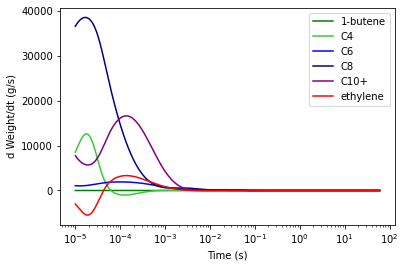

In [591]:
%matplotlib inline
plt.semilogx(rxn_time, d_c4h81, color='green', label='1-butene')
plt.semilogx(rxn_time, d_c4, color='limegreen', label='C4')
plt.semilogx(rxn_time, d_c6, color='b', label='C6')
plt.semilogx(rxn_time, d_c8, color='darkblue', label='C8')
plt.semilogx(rxn_time, d_c10, color='purple', label='C10+')
plt.semilogx(rxn_time, d_ethylene, color='red', label='ethylene')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1, shadow=False,)
plt.xlabel('Time (s)')
plt.ylabel('d Weight/dt (g/s)')
# plt.semilogx(rxn_time, d_ethylene, color='r')
# plt.show()
plt.savefig('gas_profiles_deriv.pdf', bbox_inches='tight')

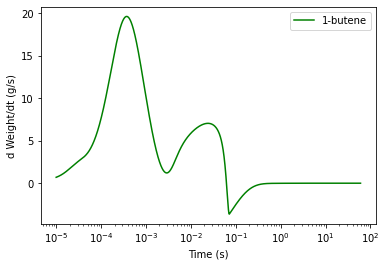

In [595]:
%matplotlib inline
plt.semilogx(rxn_time, d_c4h81, color='green', label='1-butene')
# plt.semilogx(rxn_time, d_c4, color='limegreen', label='C4')
# plt.semilogx(rxn_time, d_c6, color='b', label='C6')
# plt.semilogx(rxn_time, d_c8, color='darkblue', label='C8')
# plt.semilogx(rxn_time, d_c10, color='purple', label='C10+')
# plt.semilogx(rxn_time, d_ethylene, color='red', label='ethylene')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1, shadow=False,)
plt.xlabel('Time (s)')
plt.ylabel('d Weight/dt (g/s)')
# plt.ylim(-100,30)
# plt.semilogx(rxn_time, d_ethylene, color='r')
# plt.show()
plt.savefig('gas_profiles_deriv_zoom.pdf', bbox_inches='tight')

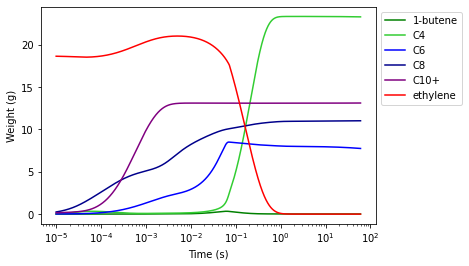

In [588]:
%matplotlib inline
plt.semilogx(rxn_time, butene1, color='green', label='1-butene')
plt.semilogx(rxn_time, c4, color='limegreen', label='C4')
plt.semilogx(rxn_time, c6, color='b', label='C6')
plt.semilogx(rxn_time, c8, color='darkblue', label='C8')
plt.semilogx(rxn_time, c10, color='purple', label='C10+')
plt.semilogx(rxn_time, ethylene, color='red', label='ethylene')
plt.xlabel('Time (s)')
plt.ylabel('Weight (g)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, shadow=False,)
# plt.xlim(0,0.2)
# plt.show()
plt.savefig('gas_profiles.pdf', bbox_inches='tight')

In [596]:
def combine_data(gas):
    c4 = [0] * len(rxn_time)
    c6 = [0] * len(rxn_time)
    c8 = [0] * len(rxn_time)
    c10 = [0] * len(rxn_time)

    for i in range(gas.n_species):
        species = gas.species(i)
        carbons = species.composition.get('C')
        index = gas.species_index(str(species.name))  # get its index, just to make sure
        assert index == i

        if carbons is None:
            continue

#         if gas.species_name(i) == 'C2H4(2)':
#             ethylene = gas_mole_fracs[i, :]
#             ethylene = [x * gas.molecular_weights[i] for x in ethylene]
#         elif gas.species_name(i) == 'C4H8-1(3)':
#             butene1 = gas_mole_fracs[i, :]
#             butene1 = [x * gas.molecular_weights[i] for x in butene1]

        if carbons == 4.:
            c4_temp = gas_mole_fracs[i, :]
            c4_temp = [x * gas.molecular_weights[i] for x in c4_temp]
            c4 = [c4[x] + c4_temp[x] for x in range(len(rxn_time))]
        elif carbons == 6.:
            c6_temp = gas_mole_fracs[i, :]
            c6_temp = [x * gas.molecular_weights[i] for x in c6_temp]
            c6 = [c6[x] + c6_temp[x] for x in range(len(rxn_time))]
        elif carbons == 8.:
            c8_temp = gas_mole_fracs[i, :]
            c8_temp = [x * gas.molecular_weights[i] for x in c8_temp]
            c8 = [c8[x] + c8_temp[x] for x in range(len(rxn_time))]
        elif carbons >= 10.:
            c10_temp = gas_mole_fracs[i, :]
            c10_temp = [x * gas.molecular_weights[i] for x in c10_temp]
            c10 = [c10[x] + c10_temp[x] for x in range(len(rxn_time))]
        
    return c4, c6, c8, c10

In [598]:
c4, c6, c8, c10 = combine_data(surf)

In [600]:
d_c4 = deriv(c4, rxn_time)
d_c6 = deriv(c6, rxn_time)
d_c8 = deriv(c8, rxn_time)
d_c10 = deriv(c10, rxn_time)

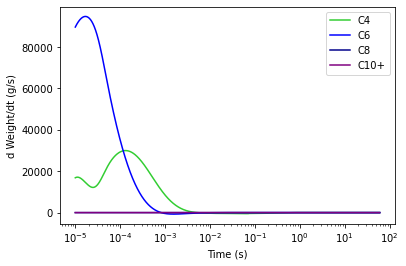

In [601]:
%matplotlib inline
# plt.semilogx(rxn_time, d_c4h81, color='green', label='1-butene')
plt.semilogx(rxn_time, d_c4, color='limegreen', label='C4')
plt.semilogx(rxn_time, d_c6, color='b', label='C6')
plt.semilogx(rxn_time, d_c8, color='darkblue', label='C8')
plt.semilogx(rxn_time, d_c10, color='purple', label='C10+')
# plt.semilogx(rxn_time, d_ethylene, color='red', label='ethylene')
plt.legend(loc='best', bbox_to_anchor=(1, 1), ncol=1, shadow=False,)
plt.xlabel('Time (s)')
plt.ylabel('d Weight/dt (g/s)')
# plt.semilogx(rxn_time, d_ethylene, color='r')
# plt.show()
plt.savefig('surf_profiles_deriv.pdf', bbox_inches='tight')

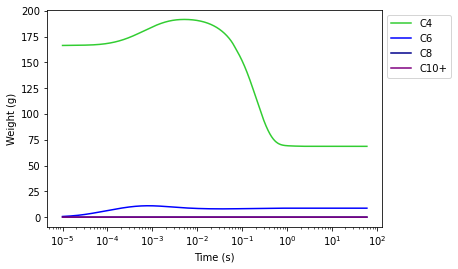

In [603]:
%matplotlib inline
# plt.semilogx(rxn_time, butene1, color='green', label='1-butene')
plt.semilogx(rxn_time, c4, color='limegreen', label='C4')
plt.semilogx(rxn_time, c6, color='b', label='C6')
plt.semilogx(rxn_time, c8, color='darkblue', label='C8')
plt.semilogx(rxn_time, c10, color='purple', label='C10+')
# plt.semilogx(rxn_time, ethylene, color='red', label='ethylene')
plt.xlabel('Time (s)')
plt.ylabel('Weight (g)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=1, shadow=False,)
# plt.xlim(0,0.2)
# plt.show()
plt.savefig('surf_profiles.pdf', bbox_inches='tight')